### Set up and Imports

In [1]:
!pip install pymssql

In [71]:
import pandas as pd
import numpy as np
from pathlib import Path
from timecal import DateTimeCalculator
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import math
from optcal.tool_funcs import ToolFuncs
import scipy.interpolate
from meta import ETFOptContracts
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

### Read Data

In [6]:
df = pd.read_csv(r"C:\Users\ps\PycharmProjects\pythonProject\data1.csv")
df = df[['TradingDate', 'Volume', 'Turnover', 'OpenInterest', 'ContractCode', 'ContractType', 'ExpirationDate']]

### Remove Duplicates

In [7]:
def drop_duplicates(date_range, num, df):
    name = pd.DataFrame()
    type_df = df[df['ContractType'] == num]
    for i in date_range:
        medium = type_df[type_df['TradingDate']==str(i)]
        modified = medium[~medium.ContractCode.duplicated(keep='first')].drop(['ContractType',], axis=1)
        new_type = modified.groupby(['TradingDate', 'ExpirationDate']).sum().drop(['ContractCode',], axis=1)
        name = pd.concat([name, new_type], axis=0)
    return name

In [8]:
date_range = pd.date_range('2015-02-09', '2023-05-17').strftime('%Y-%m-%d')

## Seperate Call and Put. Call = 2, Put = 3.
call = drop_duplicates(date_range, 2, df)
put = drop_duplicates(date_range, 3, df)

In [9]:
call

Volume      Turnover  OpenInterest
TradingDate ExpirationDate                                    
2015-02-09  2015-03-25        7397  1.043426e+07          2345
            2015-04-22        1866  2.818218e+06           980
            2015-06-24         835  1.904594e+06           639
            2015-09-23        1222  3.547205e+06           959
2015-02-10  2015-03-25        5599  7.437201e+06          3675
...                            ...           ...           ...
2023-05-16  2023-12-27        4822  6.995973e+06         14914
2023-05-17  2023-05-24      783125  2.352786e+08        884127
            2023-06-28      213863  9.507321e+07        435118
            2023-09-27       59248  2.036316e+07        116694
            2023-12-27        5489  6.720656e+06         16218

[8040 rows x 3 columns]

In [10]:
def create_rotating_list(values, repetitions):
    repeating_list = []
    for _ in range(repetitions):
        repeating_list.extend(values)
    return repeating_list

In [11]:
rotating_list = create_rotating_list([1, 2, 3, 4], 2010)
call['Terms'] = rotating_list
put['Terms'] = rotating_list

### Convert the DataFrame

In [12]:
def convert_to_target(old, cp_type):
    new = pd.DataFrame()
    new['TradingDate'] = old[old.Terms == 1 ].index.get_level_values(0)
    
    for i in old.Terms.unique():
        name = f'{i}month'
        if i >= 3:
            name = f'{i-2}quarter'
        for a in old.columns[:-1]:
            new[f'{cp_type}_{a}_{name}'] = old[old.Terms == i ].reset_index()[f'{a}']
    new.set_index('TradingDate', inplace = True)
    return new            

new_call = convert_to_target(call, "C").iloc[219:-20,:]
new_put = convert_to_target(put, "P").iloc[219:-20,:]

### Validate Data Accuracy

In [13]:
sql_df = pd.read_csv(r"C:\Users\ps\PycharmProjects\pythonProject\sql_df.csv")
sql_df = sql_df.set_index(sql_df['TRADE_DATE'])

In [14]:
call_volume = new_call.C_Volume_1month + new_call.C_Volume_2month  + new_call.C_Volume_1quarter + new_call.C_Volume_2quarter
call_oi = new_call.C_OpenInterest_1month + new_call.C_OpenInterest_2month  + new_call.C_OpenInterest_1quarter + new_call.C_OpenInterest_2quarter
put_volume = new_put.P_Volume_1month + new_put.P_Volume_2month  + new_put.P_Volume_1quarter + new_put.P_Volume_2quarter
put_oi = new_put.P_OpenInterest_1month + new_put.P_OpenInterest_2month  + new_put.P_OpenInterest_1quarter + new_put.P_OpenInterest_2quarter

In [15]:
difference = sql_df['C_VOL'] - call_volume

%matplotlib notebook
plt.figure(figsize=(10,5))
plt.grid(True)

call_volume.index = pd.to_datetime(call_volume.index)
gfg = sns.lineplot(x=call_volume.index, y=difference)


# Set the x-tick labels to display only the year
ax = plt.gca()
ax.set_xticklabels([2015,2016,2017,2018,2019,2020,2021,2022,2023], rotation=45, ha='right')


gfg.set_title( "SQL - Call VOL Difference ")
gfg.set_xlabel( "Trading Date")
gfg.set_ylabel( "Difference in Vol")
plt.show()

<IPython.core.display.Javascript object>

In [16]:
difference = sql_df['P_VOL'] - put_volume

%matplotlib notebook
plt.figure(figsize=(10,5))
plt.grid(True)

put_volume.index = pd.to_datetime(put_volume.index)
gfg = sns.lineplot(x=put_volume.index, y=difference)


# Set the x-tick labels to display only the year
ax = plt.gca()
ax.set_xticklabels([2015,2016,2017,2018,2019,2020,2021,2022,2023], rotation=45, ha='right')


gfg.set_title( "SQL - Put VOL Difference ")
gfg.set_xlabel( "Trading Date")
gfg.set_ylabel( "Difference in Vol")
plt.show()

<IPython.core.display.Javascript object>

In [17]:
difference = sql_df['C_OPEN_INT'] - call_oi

%matplotlib notebook
plt.figure(figsize=(10,5))
plt.grid(True)

call_volume.index = pd.to_datetime(call_volume.index)
gfg = sns.lineplot(x=call_volume.index, y=difference)


# Set the x-tick labels to display only the year
ax = plt.gca()
ax.set_xticklabels([2015,2016,2017,2018,2019,2020,2021,2022,2023], rotation=45, ha='right')


gfg.set_title( "SQL - Call OI Difference ")
gfg.set_xlabel( "Trading Date")
gfg.set_ylabel( "Difference in OI")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


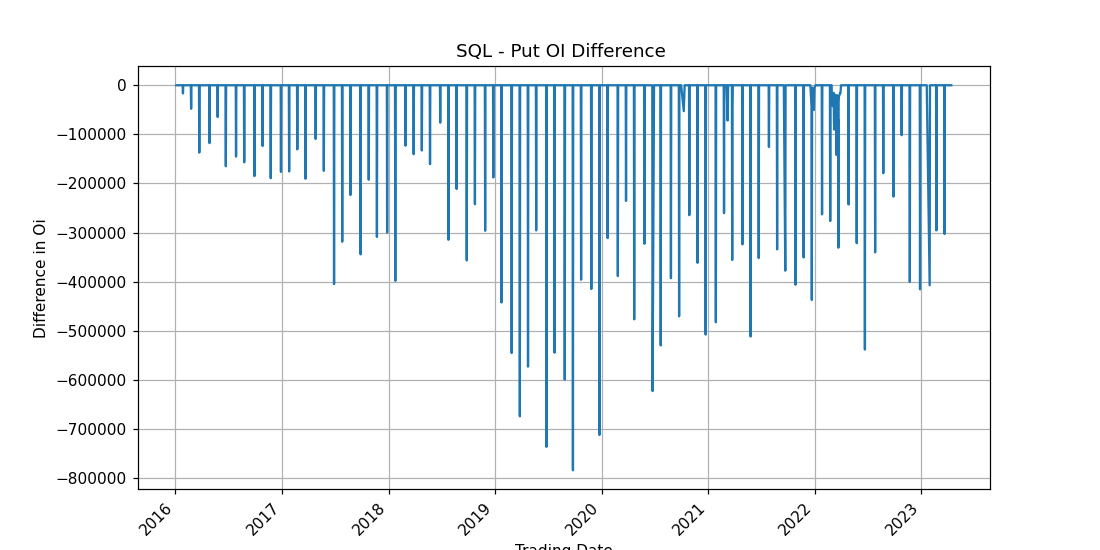

In [73]:
difference = sql_df['P_OPEN_INT'] - put_oi

%matplotlib notebook
plt.figure(figsize=(10,5))
plt.grid(True)

call_volume.index = pd.to_datetime(call_volume.index)
gfg = sns.lineplot(x=call_volume.index, y=difference)


# Set the x-tick labels to display only the year
ax = plt.gca()
ax.set_xticklabels([2015,2016,2017,2018,2019,2020,2021,2022,2023], rotation=45, ha='right')


gfg.set_title( "SQL - Put OI Difference ")
gfg.set_xlabel( "Trading Date")
gfg.set_ylabel( "Difference in Oi")
plt.show()

In [19]:
## Daily Average for VOL
c_vol_da = call_volume.sum()/len(call_volume)
s_c_vol_da = sql_df['C_VOL'].sum()/len(sql_df['C_VOL'])
print(f"The Daily Average for the 聚源 Call Volume is {c_vol_da} and the 通联 data is {s_c_vol_da}")
print(f"Their percentage difference is {(s_c_vol_da - c_vol_da)/s_c_vol_da}\n")

p_vol_da = put_volume.sum()/len(put_volume)
s_p_vol_da = sql_df['P_VOL'].sum()/len(sql_df['P_VOL'])
print(f"The Daily Average for the 聚源 Put Volume is {p_vol_da} and the 通联 data is {s_p_vol_da}")
print(f"Their percentage difference is {(s_p_vol_da - p_vol_da)/s_p_vol_da}\n")

## Daily Average for OI
c_oi_da = call_oi.sum()/len(call_oi)
s_c_oi_da = sql_df['C_OPEN_INT'].sum()/len(sql_df['C_OPEN_INT'])
print(f"The Daily Average for the 聚源 Call OI is {c_oi_da} and the 通联 data is {s_c_oi_da}")
print(f"Their percentage difference is {(s_c_oi_da - c_oi_da)/s_c_oi_da}\n")

p_oi_da = put_oi.sum()/len(put_oi)
s_p_oi_da = sql_df['P_OPEN_INT'].sum()/len(sql_df['P_OPEN_INT'])
print(f"The Daily Average for the 聚源 Put OI is {p_oi_da} and the 通联 data is {s_p_oi_da}")
print(f"Their percentage difference is {(s_p_oi_da - p_oi_da)/s_p_oi_da}")

The Daily Average for the 聚源 Call Volume is 940698.7888198758 and the 通联 data is 940698.7888198758
Their percentage difference is 0.0

The Daily Average for the 聚源 Put Volume is 778521.6137775268 and the 通联 data is 778521.6137775268
Their percentage difference is 0.0

The Daily Average for the 聚源 Call OI is 1292788.1377752682 and the 通联 data is 1269255.6363636365
Their percentage difference is -0.018540395439212955

The Daily Average for the 聚源 Put OI is 1051053.196499153 and the 通联 data is 1034650.3235460191
Their percentage difference is -0.01585354257360779


#### The above Open Interest Difference can be ignored, which only occurs on the expiration date, every month's fourth Wendesday.


#### We used the data obtained from [聚源](https://www.gildata.com/) to compare with the one from [通联](https://m.datayes.com/) . The former includes the OI for nearest 1m OI data on the expiration date while the latter does not.


#### For our final ouput features, we will use the data from 聚源.

### - 

## Forming Features

#### <font color='green'> Features To-do List: </font>
-  **high:** Highest price on ula on the given trading day


-  **low:** Lowest price on ula on the given trading day


-  **open:** Opening price on ula on the given trading day


-  **close:** Closing price on ula on the given trading day


-  **ula_volume:** Total volume of ula on th given trading day


-  **op_volume:** Total volume of option on th given trading day


-  **option_turnover:** Total volume of option * Multiplier


-  **ula_turnover:** Total volume of option * Multiplier


-  **ula_ma5, ula_ma20, ula_ma60**: Moving Average of ula's closing price for a range of trading days.


-  **ula_vol_ma5, ula_vol_ma20, ula_vol_ma60**: Moving Average of option's IV for a range of trading days.


-  **OI PCR (Open Interest Put Call Ratio):** Active_Put.sum / Active_Call.sum


-  **Volume PCR:** Put_volume.sum / Call_volume.sum


-  **price_return:** ula close day return (log)


-  **vol:** ATM_VOL


-  **skew**


-  **kurtosis**

# - 

### 1）Computing Volume and Open Interest's Put Call Ratio

In [20]:
features = pd.DataFrame()
features = pd.concat([features, new_call], axis=0)
features = pd.concat([features, new_put], axis=1)

## Compute Open Interest Put Call Ratio and Volume Put Call Ratio
def compute_new_features(old, cp_type, list_of_features, list_of_terms):
    for i in list_of_features:
        for term in list_of_terms:
            old[f'{i}_pcr_{term}'] = old[f'{cp_type[-1]}_{i}_{term}']/old[f'{cp_type[0]}_{i}_{term}']
    return old
        
        
old = features
cp_type = ['C', 'P']
list_of_features = ['Volume', 'OpenInterest']
list_of_terms = ['1month', '2month', '1quarter', '2quarter']
features = compute_new_features(old, cp_type, list_of_features, list_of_terms)

# - 




### 2) Adding Underlying Asset's Info, 50 ETF

In [21]:
etf= pd.read_csv(r"C:\Users\ps\PycharmProjects\pythonProject\first_garch_df.csv")
etf.set_index('tradingday', inplace = True)
etf = etf.iloc[6:-3,:]

In [22]:
## Adding open, high, low, close, volume, turnover, price_return, 
features = pd.concat([features, etf], axis=1)

renamed_columns = {'open': 'ula_open', 'high': 'ula_high','low': 'ula_low','close': 'ula_close','turnover': 'ula_turnover',
                  'prev_close': 'ula_prev_close','price_return': 'ula_price_return'}
features = features.rename(columns=renamed_columns)

In [23]:
features.index = pd.to_datetime(features.index)

In [24]:
features.columns

Index(['C_Volume_1month', 'C_Turnover_1month', 'C_OpenInterest_1month',
       'C_Volume_2month', 'C_Turnover_2month', 'C_OpenInterest_2month',
       'C_Volume_1quarter', 'C_Turnover_1quarter', 'C_OpenInterest_1quarter',
       'C_Volume_2quarter', 'C_Turnover_2quarter', 'C_OpenInterest_2quarter',
       'P_Volume_1month', 'P_Turnover_1month', 'P_OpenInterest_1month',
       'P_Volume_2month', 'P_Turnover_2month', 'P_OpenInterest_2month',
       'P_Volume_1quarter', 'P_Turnover_1quarter', 'P_OpenInterest_1quarter',
       'P_Volume_2quarter', 'P_Turnover_2quarter', 'P_OpenInterest_2quarter',
       'Volume_pcr_1month', 'Volume_pcr_2month', 'Volume_pcr_1quarter',
       'Volume_pcr_2quarter', 'OpenInterest_pcr_1month',
       'OpenInterest_pcr_2month', 'OpenInterest_pcr_1quarter',
       'OpenInterest_pcr_2quarter', 'ula_open', 'ula_high', 'ula_low',
       'ula_close', 'volume', 'ula_turnover', 'ula_prev_close',
       'ula_price_return', 'ula_ma5', 'ula_ma20', 'ula_ma60', 'ula_vol_ma

In [25]:
features

C_Volume_1month  C_Turnover_1month  C_OpenInterest_1month   
2016-01-04            66383         33093135.0                 145347  \
2016-01-05           126907         58850594.0                 163306   
2016-01-06            86468         40493942.0                 166950   
2016-01-07            17171          6401139.0                 168476   
2016-01-08           130090         59087387.0                 187378   
...                     ...                ...                    ...   
2023-04-10           497569        213781953.0                 740105   
2023-04-11           553012        221623779.0                 765477   
2023-04-12           492159        168743102.0                 801769   
2023-04-13           625412        215611102.0                 765910   
2023-04-14           652083        254970442.0                 748626   

            C_Volume_2month  C_Turnover_2month  C_OpenInterest_2month   
2016-01-04             6460          3580664.0                  10652  \
2016-01-05            12616          8137192.0                  14110   
2016-01-06             5220          3058123.0                  15473   
2016-01-07             2473          1248189.0                  16463   
2016-01-08            23015         15454628.0                  25046   
...                     ...                ...                    ...   
2023-04-10            49638         23625695.0                  90727   
2023-04-11            57252         27813556.0                 103933   
2023-04-12            68584         27398765.0                 118993   
2023-04-13            78532         28713435.0                 130943   
2023-04-14            93757         38409478.0                 138170   

            C_Volume_1quarter  C_Turnover_1quarter  C_OpenInterest_1quarter   
2016-01-04              14986          14840193.00                    75926  \
2016-01-05              14932          11977096.00                    76241   
2016-01-06               9470          13236434.00                    78944   
2016-01-07               3217           2404845.00                    79626   
2016-01-08              19458          18549498.00                    81790   
...                       ...                  ...                      ...   
2023-04-10              91193          26541099.32                   181143   
2023-04-11             115456          31465546.29                   187835   
2023-04-12             101765          27836232.50                   193179   
2023-04-13             128010          34061713.78                   200762   
2023-04-14             186955          47744441.60                   207004   

            C_Volume_2quarter  ...      volume  ula_turnover  ula_prev_close   
2016-01-04               2236  ...  29854.6954  7.037605e+08           2.416  \
2016-01-05               2519  ...  64569.9581  1.473642e+09           2.278   
2016-01-06               1115  ...  40095.3404  9.213985e+08           2.286   
2016-01-07                324  ...   8916.6922  1.998517e+08           2.317   
2016-01-08               3710  ...  57667.6937  1.279000e+09           2.177   
...                       ...  ...         ...           ...             ...   
2023-04-10               5845  ...  42748.7549  1.148831e+09           2.689   
2023-04-11               6717  ...  51347.5640  1.379171e+09           2.690   
2023-04-12               6233  ...  35298.7311  9.439609e+08           2.684   
2023-04-13               7397  ...  42609.6748  1.136775e+09           2.669   
2023-04-14               7340  ...  37587.5152  1.008943e+09           2.673   

            ula_price_return  ula_ma5  ula_ma20  ula_ma60  ula_vol_ma5   
2016-01-04         -0.058815   2.3924   0.84630  0.282100  29815.26032  \
2016-01-05          0.003506   2.3672   0.96060  0.320200  37248.43958   
2016-01-06          0.013470   2.3442   1.07645  0.358817  39328.58198   
2016-01-07         -0.062325   2.2948   1.18530  0.3

# -




### 3) Adding At-the-money Implied Volatility, Skewness, and Kurtosis

In [26]:
features.index = pd.to_datetime(features.index)

In [27]:
etf_metas = ETFOptContracts('510050')

# Raw SQL Date
k = pd.read_csv(r"C:\Users\ps\PycharmProjects\pythonProject\data3.csv")
k = k.drop(['Unnamed: 0', ], axis=1)
k.TradingDate = pd.to_datetime(k.TradingDate)

features = pd.read_csv(r"C:\Users\ps\PycharmProjects\pythonProject\Features_Finalization.csv")
features.tradingday = pd.to_datetime(features.tradingday)

#### Define the necessary functions for computation
 -  load_ula_price
 -  df_drop_duplicates
 -  get_imp_vol
 - get_greeks
 - indicator_generation
 - plot_inter_all
 - list_to_df
 - create_prices

In [39]:
def load_ula_price(full_year_code):
    root = Path(r"\\192.168.0.88\Public\OptionDesk\DATA\database\1day_bar\etf_by_optmon\510050")
    targ_month = root.joinpath(full_year_code[2:])
    # Specific contract code inside the folder
    contract_code = '510050'
    file = targ_month.joinpath(f'{contract_code}.pkl')
    return pd.read_pickle(str(file))

In [40]:
def df_drop_duplicates(date_range, num, df):
    name = pd.DataFrame()
    type_df = df[df['ContractType'] == num]
    for i in date_range:
        medium = type_df[type_df['TradingDate'] == str(i)]
        modified = medium[~medium.ContractCode.duplicated(keep='first')].drop(['ContractType', ], axis=1)
        new_type = modified.groupby(['TradingDate', 'ExpirationDate']).sum().drop(['ContractCode', ], axis=1)
        name = pd.concat([name, new_type], axis=0)
    return name

In [41]:
def get_imp_vol(cp_type, ud_prc, k, ttm, r, div, option_prc):
    # parameter type: str, float, float, float, float, float, float
    # returns implied volatility, type list of floats

    # parameters:
    max_vol_adj = 0.1

    # 档位
    if ud_prc <= 0:
        return 1e-4  # 负ud价格不能计算 vol。直接返回最小值。
    if cp_type == 'P':
        if k - ud_prc >= option_prc:
            return 1e-4  # 负的时间价值
    elif cp_type == 'C':
        if ud_prc - k >= option_prc:
            return 1e-4

    sqrt_t = math.sqrt(ttm)
    exp_dt = math.exp(div * ttm)
    exp_mns_dt = 1 / exp_dt  # math.exp(-div * ttm)
    exp_mns_rt = math.exp(-r * ttm)
    # take a guess: impliedvol = 0.25
    imp_vol = 0.25
    max_iterations = 30
    for i in range(0, max_iterations):
        up = math.log(ud_prc / k) + ttm * (r - div + imp_vol * imp_vol / 2)
        down = imp_vol * sqrt_t
        d1 = up / down
        d2 = d1 - down
        if cp_type == 'C':
            Nd1 = ToolFuncs.cdf(d1)
            Nd2 = ToolFuncs.cdf(d2)
            bs_price = ud_prc * exp_mns_dt * Nd1 - k * exp_mns_rt * Nd2  # corrected by Chenhao on 10.12: 加负号
        elif cp_type == 'P':
            N_d1 = ToolFuncs.cdf(-d1)
            N_d2 = ToolFuncs.cdf(-d2)
            bs_price = k * exp_mns_rt * N_d2 - ud_prc * exp_mns_dt * N_d1  # corrected by Chenhao on 10.12: 加负号
        else:
            raise ValueError(f'wrong cp_type: {cp_type}')

        if abs(bs_price - option_prc) <= 0.0001 or imp_vol < 1e-8:
            return imp_vol

        ed1 = ToolFuncs.ndf(d1)
        vega = ud_prc * exp_dt * sqrt_t * ed1
        if vega < 1e-12:
            vega = 1e-12
        delta_vol = (option_prc - bs_price) / vega
        delta_vol = min(delta_vol, max_vol_adj)
        delta_vol = max(delta_vol, -max_vol_adj)
        imp_vol = max(delta_vol + imp_vol, imp_vol / 1000)
    return imp_vol

In [42]:
def get_greeks(cp_type, ud_prc, k, ttm, r, div, vol):
    """

    :param cp_type:
    :param ud_prc:
    :param k:
    :param ttm:
    :param r:
    :param vol:
    :param div:
    :return: delta, gamma, vega, theta, rho, vanna, vomma
    """
    # parameter type: str, float, float, float, float, float, float
    # returns BSGreeks, type list of float

    sqrt_t = math.sqrt(ttm)
    up = math.log(ud_prc / k) + ttm * (r - div + vol * vol / 2)
    down = vol * math.sqrt(ttm)
    d1 = up / down
    d2 = d1 - down
    # expDT = math.exp( div * t ) # corrected on 2021-07-29 by XING
    exp_mns_dt = math.exp(-div * ttm)
    exp_mns_rt = math.exp(-r * ttm)

    # delta
    Nd1 = ToolFuncs.cdf(d1)
    if cp_type == 'C':
        delta = exp_mns_dt * Nd1
    elif cp_type == 'P':
        delta = exp_mns_dt * (Nd1 - 1)
    else:
        raise ValueError('Wrong cp_type')

    # gamma
    ed1 = ToolFuncs.ndf(d1)
    gamma = exp_mns_dt / ud_prc / vol / sqrt_t * ed1

    Nd2 = ToolFuncs.cdf(d2)
    N_d2 = ToolFuncs.cdf(-d2)

    # rho
    if cp_type == 'C':
        rho = k * ttm * exp_mns_rt * Nd2  # / 100
    elif cp_type == 'P':
        rho = -k * ttm * exp_mns_rt * N_d2  # / 100
    else:
        raise ValueError('Wrong cp_type')

    a = ud_prc * vol * exp_mns_dt / (2 * sqrt_t) * ed1
    N_d1 = ToolFuncs.cdf(-d1)
    # theta
    # annualTradingDays = 245
    if cp_type == 'C':
        b = r * k * exp_mns_rt * Nd2
        c = div * ud_prc * exp_mns_dt * Nd1  # corrected on 2021-07-29 by XING
        theta = (-a - b + c)  # / annualTradingDays
    elif cp_type == 'P':
        b = r * k * exp_mns_rt * N_d2
        c = div * ud_prc * exp_mns_dt * N_d1  # corrected on 2021-07-29 by XING
        theta = (-a + b - c)  # / annualTradingDays
    else:
        raise ValueError('Wrong cp_type')

    # vega
    vega = ud_prc * exp_mns_dt * sqrt_t * ed1  # / 100  # corrected on 2021-07-29 by XING

    # reference for above : https://www.macroption.com/black-scholes-formula/

    return [delta, gamma, vega, theta, rho]

In [43]:
def indicator_generation(delta_c_list, delta_p_list, c_iv_list, p_iv_list, seperator_c):
    # Interpolate and Calculate ATM_VOL, Skew_10, Skew_25, Kurtosis_10, and Kurtosis_25
    delta_cp_list = delta_p_list[:seperator_c] + delta_c_list[seperator_c:]
    iv_cp_list = p_iv_list[:seperator_c] + c_iv_list[seperator_c:]

    # Interpolation set up
    y_cp_interp = scipy.interpolate.interp1d(delta_cp_list, iv_cp_list)

    # Extrapolation set up
    f = scipy.interpolate.interp1d(delta_cp_list, iv_cp_list, fill_value='extrapolate')

    delta_range = [0.5, 0.75, 0.6, 0.25, 0.4]
    keys = ['vol_50', 'vol_75', 'vol_60', 'vol_25', 'vol_40']
    interp_range = {key: None for key in keys}

    for a, b in enumerate(delta_range):
        try:
            interp_range[keys[a]] = f(b)
        except:
            interp_range[keys[a]] = y_cp_interp(b)

    # Calculate the four indicators
    delta_25_skew = interp_range['vol_25'] / interp_range['vol_75']
    delta_10_skew = interp_range['vol_40'] / interp_range['vol_60']
    kurtosis_25 = (interp_range['vol_25'] + interp_range['vol_75']) / (2 * interp_range['vol_50'])
    kurtosis_10 = (interp_range['vol_40'] + interp_range['vol_60']) / (2 * interp_range['vol_50'])
    atm_vol = interp_range['vol_50']

    return delta_25_skew, delta_10_skew, kurtosis_25, kurtosis_10, atm_vol

In [44]:
def plot_inter_all(x, y, z, e):
    f = scipy.interpolate.interp1d(x, y)
    xnew = np.arange(min(x), max(x), 0.025)
    ynew = f(xnew)
    plt.plot(x, y, ',', color=str(z))
    plt.plot(xnew, ynew, '-', color=str(z), label=f'Due_{e + 1}')

In [45]:
def list_to_df(five_features, Title):
    feature_df = pd.DataFrame()
    for feature in five_features:
        for sequence in feature:
            index = sequence + 1
            column_name = f'{Title[five_features.index(feature)]}_due_{index}'
            feature_df[column_name] = feature[sequence]
    return feature_df

In [46]:
def create_prices(old, correspond_index):
    date_range = correspond_index
    dtc = DateTimeCalculator()
    old.TradingDate = pd.to_datetime(old.TradingDate)
    old = old[old.TradingDate.isin(date_range)]

    count = 0

    Skew_25 = {0: [], 1: [], 2: [], 3: []}
    Skew_10 = {0: [], 1: [], 2: [], 3: []}
    Kur_25 = {0: [], 1: [], 2: [], 3: []}
    Kur_10 = {0: [], 1: [], 2: [], 3: []}
    A = {0: [], 1: [], 2: [], 3: []}

    for date in date_range:

        # # Take out the last four days before expirations
        # full_year_code = date.replace('-','')[:-2]
        # last_four = load_ula_price(full_year_code).index[-4:]
        # if date in last_four:
        #     continue

        # # todo for debugg to fix delta
        # if date != '2019-05-29':
        #     continue

        call_price = old[old.ContractType == 2]
        put_price = old[old.ContractType == 3]

        # Call and K
        c_middleman = call_price[call_price.TradingDate == date]
        c_middleman.drop_duplicates(subset='ContractCode', inplace=True)
        c_middleman = c_middleman.reset_index().drop(['index', ], axis=1)

        # Update the StrikePrice
        for row in range(len(c_middleman)):
            calculator = etf_metas.get_contract_meta(str(c_middleman.loc[row]['ContractCode']))

            timestamp = c_middleman.loc[row]['TradingDate']
            timestamp_str = timestamp.strftime("%Y-%m-%d %H:%M:%S")[:-9].replace('-', '')

            correct_strike = calculator.get_strike(timestamp_str)
            c_middleman.at[row, 'StrikePrice'] = float(correct_strike)

        k_list = c_middleman.StrikePrice
        c_list = c_middleman.ClosePrice
        exp_list = c_middleman.ExpirationDate
        contract_list = c_middleman.ContractCode

        # Put
        p_middleman = put_price[put_price.TradingDate == date]
        p_middleman.drop_duplicates(subset='ContractCode', inplace=True)
        p_middleman = p_middleman.reset_index().drop(['index', ], axis=1)
        p_list = p_middleman.ClosePrice

        # DateFrame with K, C, and P
        functional_df = pd.DataFrame()
        functional_df = pd.concat([functional_df, k_list], axis=1)
        functional_df = pd.concat([functional_df, c_list], axis=1)
        functional_df.rename(columns={'ClosePrice': 'C_ClosePrice'}, inplace=True)
        functional_df = pd.concat([functional_df, p_list], axis=1)
        functional_df.rename(columns={'ClosePrice': 'P_ClosePrice'}, inplace=True)
        functional_df = pd.concat([functional_df, exp_list], axis=1)
        functional_df = pd.concat([functional_df, contract_list], axis=1)

        functional_df = functional_df.sort_values('StrikePrice', ascending=True)

        # Calculate ATMVOL, Skew, Kurtosis for each trading date with its corrsponding due date
        list_of_expiries = np.sort(c_middleman.ExpirationDate.unique())

        for num in range(len(list_of_expiries)):
            new_functional_df = functional_df[functional_df['ExpirationDate'] == list_of_expiries[num]]
            new_functional_df = new_functional_df.reset_index().drop(['index', ], axis=1)

            # Calculating ula price with ATM Forward
            diff_cp_list = new_functional_df['C_ClosePrice'] - new_functional_df['P_ClosePrice']
            min_row = new_functional_df.loc[np.nanargmin(abs(diff_cp_list))]
            k_atm, c_atm, p_atm = min_row.StrikePrice, min_row.C_ClosePrice, min_row.P_ClosePrice
            ula_price = c_atm - p_atm + k_atm

            # Calculate IV row by row
            c_iv_list = []
            p_iv_list = []

            cur_date = date.replace('-', '')
            exp_date = list_of_expiries[num].strip('-').replace('-', '')

            ttm = dtc.get_days_diff(cur_date, exp_date) / 252
            ud_prc = ula_price
            r = 0
            div = 0
            c_type = 'C'
            p_type = 'P'

            # todo: Later try to modify into form of DataFrame and see if it works
            for row in range(len(new_functional_df)):
                k = new_functional_df['StrikePrice'][row]
                c_option_prc = new_functional_df['C_ClosePrice'][row]
                p_option_prc = new_functional_df['P_ClosePrice'][row]

                c_iv = get_imp_vol(c_type, ud_prc, k, ttm, r, div, c_option_prc)
                p_iv = get_imp_vol(p_type, ud_prc, k, ttm, r, div, p_option_prc)

                c_iv_list.append(c_iv)
                p_iv_list.append(p_iv)

            new_functional_df['c_iv'] = c_iv_list
            new_functional_df['p_iv'] = p_iv_list

            # Calculate Delta row by row
            delta_c_list = []
            delta_p_list = []

            for row in range(len(new_functional_df)):
                k = new_functional_df['StrikePrice'][row]
                c_iv = new_functional_df['c_iv'][row]
                p_iv = new_functional_df['p_iv'][row]

                delta_c = get_greeks(c_type, ud_prc, k, ttm, r, div, c_iv)[0]
                delta_p = get_greeks(p_type, ud_prc, k, ttm, r, div, p_iv)[0]

                delta_c_list.append(1 - delta_c)
                delta_p_list.append(abs(delta_p))

            delta_c_list = sorted(delta_c_list)
            delta_p_list = sorted(delta_p_list)

            # Calculate OTM Call and Put's Delta and IV
            try:
                seperator_c = np.where(np.array(delta_c_list) > 0.5)[0][0]
                delta_25_skew, delta_10_skew, kurtosis_25, kurtosis_10, atm_vol = \
                    indicator_generation(delta_c_list, delta_p_list, c_iv_list, p_iv_list, seperator_c)
                if atm_vol > 1.0:
                    print(f'Today is {date} with {num}th due date {list_of_expiries[num]} with ttm as {ttm * 252}')

            except IndexError:
                count += 1
                # print(f'Today is {date} with {num}th due date {list_of_expiries[num]}')
                # print(f'IndexError{count} and ttm is {ttm}: \n')
                # print(f'the delta_c_list is {delta_c_list} \n')
                # print(f'the delta_p_list is {delta_p_list}\n')
                # print(f'____________________________________________________________________')
                delta_25_skew = None
                delta_10_skew = None
                kurtosis_25 = None
                kurtosis_10 = None
                atm_vol = None

            Skew_25[num].append(delta_25_skew)
            Skew_10[num].append(delta_10_skew)
            Kur_25[num].append(kurtosis_25)
            Kur_10[num].append(kurtosis_10)
            A[num].append(atm_vol)

    return Skew_25, Skew_10, Kur_25, Kur_10, A

### Call function and save it to local CSV

In [47]:
Skew_25, Skew_10, Kur_25, Kur_10, A = create_prices(k, features.tradingday)

five_features = [Skew_25, Skew_10, Kur_25, Kur_10, A]
Title = ['Skew_25D', 'Skew_10D', 'Kurtosis_25D', 'Kurtosis_10D', "ATMVOL"]

feature_df = list_to_df(five_features, Title)
feature_df['next_ATMVOL_due_1'] = feature_df['ATMVOL_due_1'].shift(-1)
feature_df['IV_return_due_1'] = feature_df['next_ATMVOL_due_1'] / feature_df['ATMVOL_due_1']
feature_df.to_csv(r"C:\Users\ps\PycharmProjects\pythonProject\final_feature_df.csv")

# -

### Test accuracy by plotting all nearest month expiration date for in between 2018-03-29 and 2018-04-25

In [107]:
# #######################################################################################################
# # Plot the Call VOL vs. K
# plt.clf()
# fig = plt.figure()
# plt.subplot(1, 2, 1)
# k_plot_list = [float(i) for i in new_functional_df.StrikePrice]
# # Linear Interpolation
# y_c_interp = scipy.interpolate.interp1d(k_plot_list, c_iv_list)
# k_val = np.linspace(min(k_plot_list), max(k_plot_list), 50)
# vol_c_interp = y_c_interp(k_val)

# plt.plot(k_plot_list, c_iv_list, '^', color='r')
# plt.plot(k_val, vol_c_interp, '-.', color='r', label='Call_imp_vol')

# # Call Annotate
# mask = np.array([(ele > ula_price) for ele in k_plot_list])
# annotate_list = np.array(k_plot_list)[mask]
# for i in range(3):
#     annotate_index = k_plot_list.index(annotate_list[i])
#     vol_annotate = c_iv_list[annotate_index]
#     plt.annotate(text=f'{round(100 * vol_annotate, 2)}%', xy=(annotate_list[i], vol_annotate),
#                  xytext=(annotate_list[i] + i * 0.05, vol_annotate - 0.05),
#                  arrowprops=dict(arrowstyle='<|-|>', connectionstyle='angle', color='red'))

# # Plot the Put VOL vs. K
# # Linear Interpolation
# y_p_interp = scipy.interpolate.interp1d(k_plot_list, p_iv_list)
# vol_p_interp = y_p_interp(k_val)

# plt.plot(k_plot_list, p_iv_list, 'v', color='b')
# plt.plot(k_val, vol_p_interp, '-.', color='b', label='Put_imp_vol')

# plt.axvline(x=ula_price, color='cyan', linestyle='dashdot', label='ATM_forward_price')
# plt.legend()
# plt.xlim(2.3, 3.3)
# plt.ylim(0.13, 0.46)

# plt.title(f'Implied volatility {date} with ula {ula_price} at 14:59:00 vs strike')

# # Put Annotate
# mask = np.array([(ele < ula_price) for ele in k_plot_list])
# annotate_list = np.array(k_plot_list)[mask]
# for i in range(1, 4):
#     annotate_index = k_plot_list.index(annotate_list[-i])
#     vol_annotate = p_iv_list[annotate_index]
#     plt.annotate(text=f'{round(100 * vol_annotate, 2)}%', xy=(annotate_list[-i], vol_annotate),
#                  xytext=(annotate_list[-i] - i * 0.05, vol_annotate - 0.05),
#                  arrowprops=dict(arrowstyle='<|-|>', connectionstyle='angle', color='blue'))
# ########################################################################################################

# # Plot the Call VOL vs. Delta
# plt.subplot(1, 2, 2)

# # Linear Interpolation
# y_cd_interp = scipy.interpolate.interp1d(delta_c_list, c_iv_list)
# delta_val = np.linspace(min(delta_c_list), max(delta_c_list), 50)
# vol_interp = y_cd_interp(delta_val)

# plt.plot(delta_c_list, c_iv_list, '^', color='r')
# plt.plot(delta_val, vol_interp, '-.', color='r', label='Call_imp_vol')

# # Plot for Put Delta and Vol

# # Linear Interpolation
# y_interp = scipy.interpolate.interp1d(delta_p_list, p_iv_list)
# delta_val = np.linspace(min(delta_p_list), max(delta_p_list), 50)
# vol_interp = y_interp(delta_val)

# plt.plot(delta_p_list, p_iv_list, 'v', color='b')
# plt.plot(delta_val, vol_interp, '-.', color='b', label='Put_imp_vol')

# plt.title(f'Implied volatility {date} with ula {ula_price} at 14:59:00 vs delta')
# plt.axvline(x=0.5, color='cyan', linestyle='dashdot', label='0.5 delta')
# plt.axvline(x=0.25, color='purple', linestyle='--', label='0.25 delta put')
# plt.axvline(x=0.75, color='orange', linestyle='--', label='0.25 delta call')
# plt.legend()
# plt.xlim(0.0, 1.0)
# plt.ylim(0.13, 0.46)

# # Call Annotate
# mask = np.array([(ele > 0.5) for ele in delta_c_list])
# annotate_list = np.array(delta_c_list)[mask]
# for i in range(3):
#     annotate_index = delta_c_list.index(annotate_list[i])
#     vol_annotate = c_iv_list[annotate_index]
#     plt.annotate(text=f'{round(100 * vol_annotate, 2)}%', xy=(annotate_list[i], vol_annotate),
#                  xytext=(annotate_list[i] + i * 0.05, vol_annotate - 0.05),
#                  arrowprops=dict(arrowstyle='<|-|>', connectionstyle='angle', color='red'))
# #
# # Put Annotate
# mask = np.array([(ele < 0.5) for ele in delta_c_list])
# annotate_list = np.array(delta_c_list)[mask]
# for i in range(1, 4):
#     annotate_index = delta_c_list.index(annotate_list[-i])
#     vol_annotate = p_iv_list[annotate_index]
#     plt.annotate(text=f'{round(100 * vol_annotate, 2)}%', xy=(annotate_list[-i], vol_annotate),
#                  xytext=(annotate_list[-i] - i * 0.05, vol_annotate - 0.05),
#                  arrowprops=dict(arrowstyle='<|-|>', connectionstyle='angle',
#                                  color='blue'))

# # fig = plt.figure()
# count += 1
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)
# plt.savefig(f'{count}_Features.png')
# ##########################################################################################################

<IPython.core.display.Javascript object>


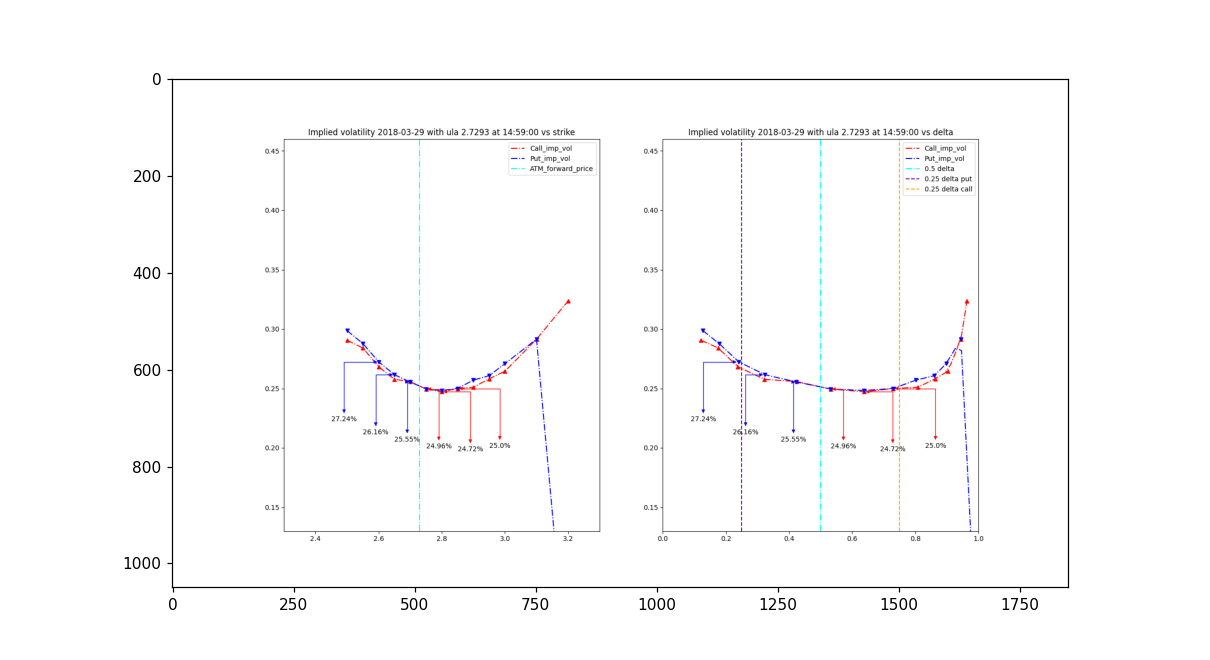

In [86]:
# Left: Implied volatiltiy 2018-03-29 with ula 2.7293 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-03-29 with ula 2.7293 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\1_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


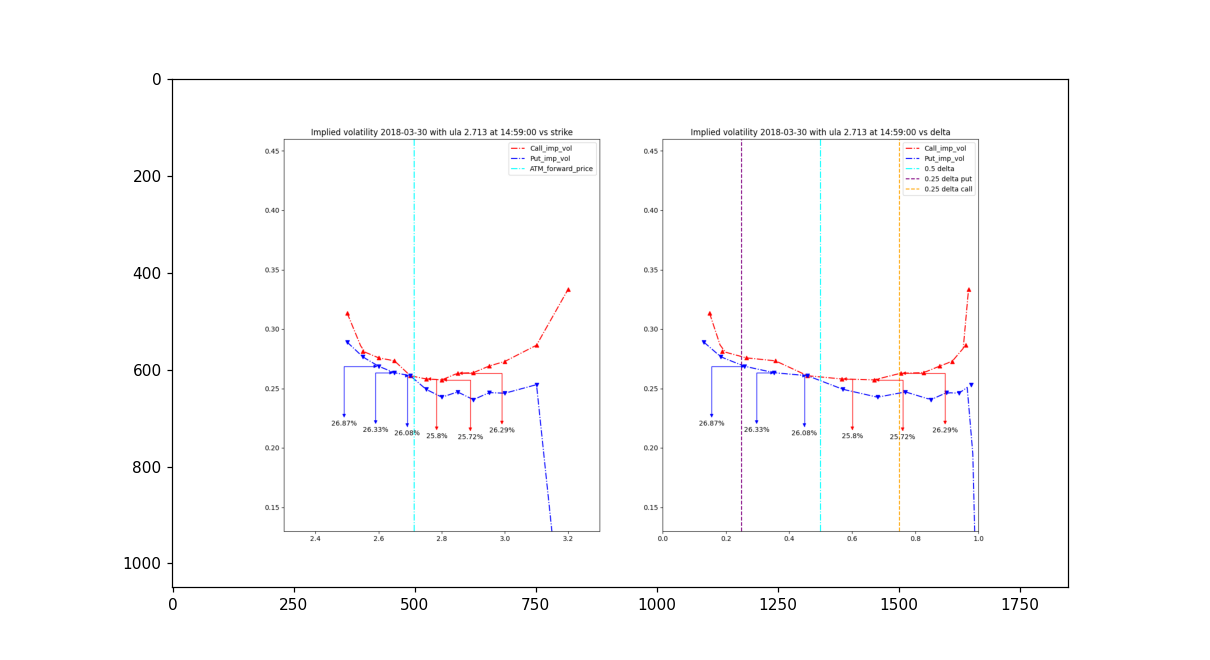

In [87]:
# Left: Implied volatiltiy 2018-03-30 with ula 2.713 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-03-30 with ula 2.713 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\2_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


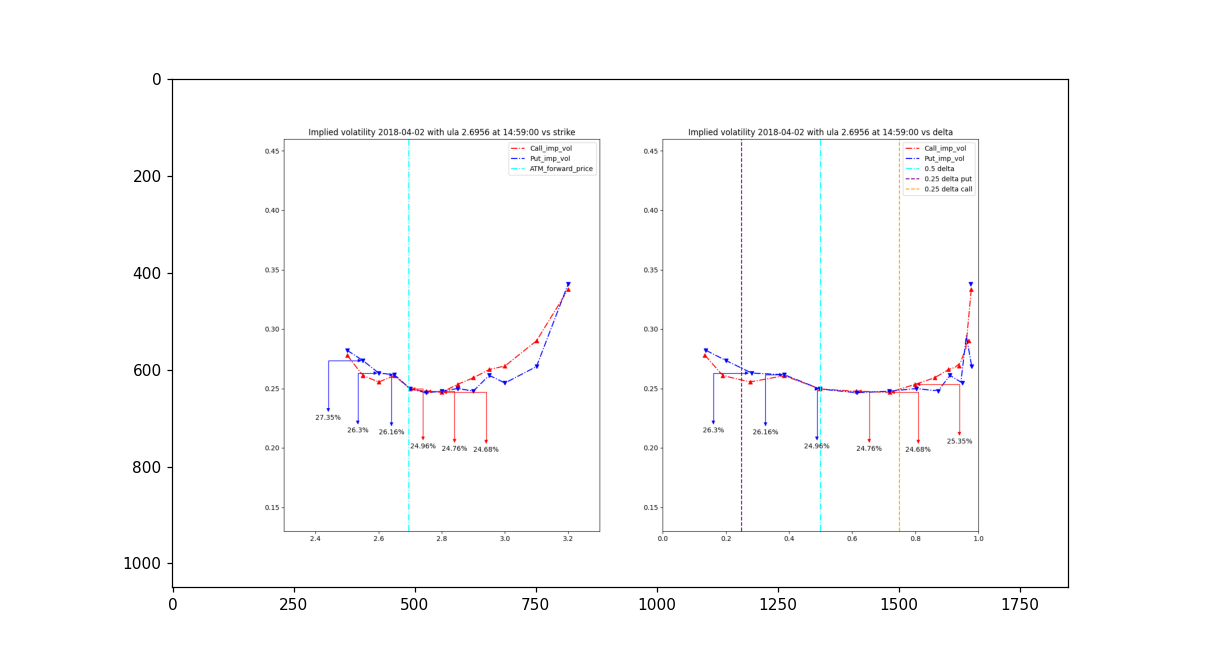

In [88]:
# Left: Implied volatiltiy 2018-04-02 with ula 2.6956 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-02 with ula 2.6956 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\3_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


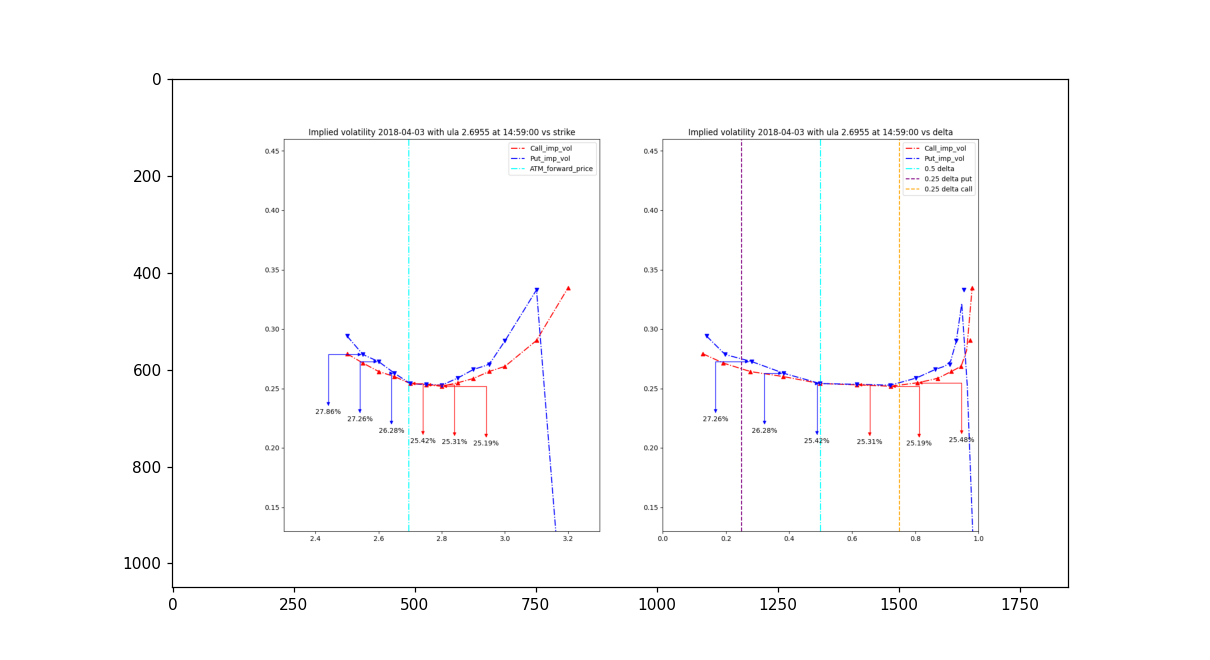

In [90]:
# Left: Implied volatiltiy 2018-04-03 with ula 2.6955 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-03 with ula 2.6955 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\4_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


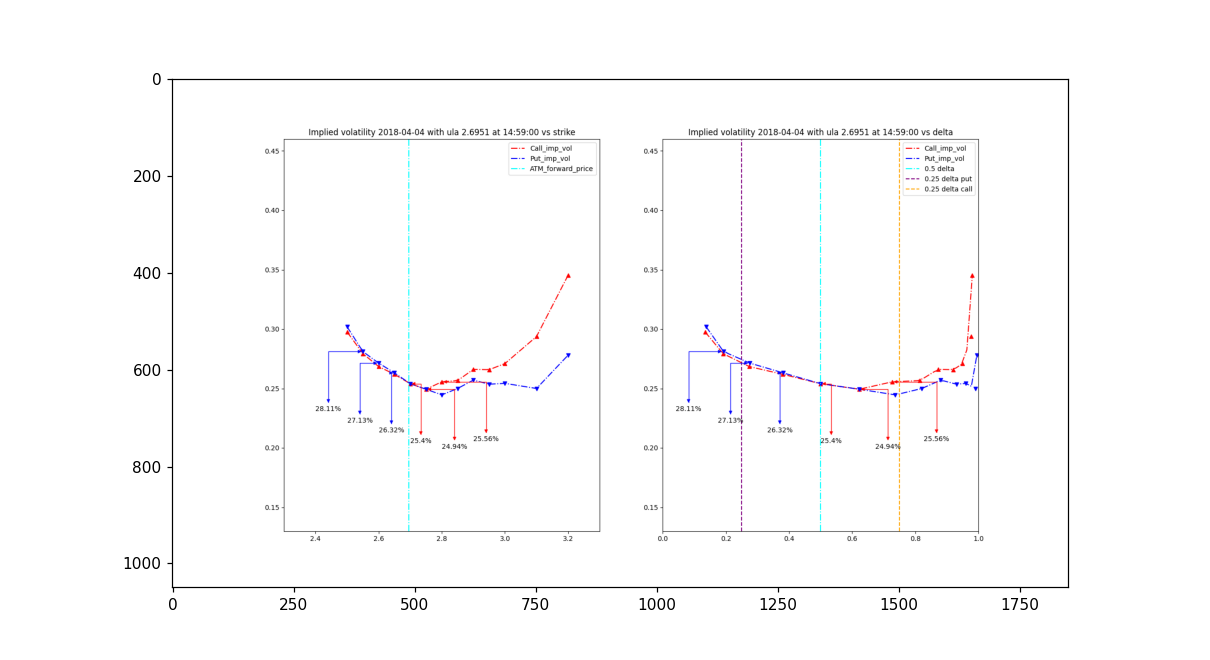

In [91]:
# Left: Implied volatiltiy 2018-04-04 with ula 2.6951 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-04 with ula 2.6951 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\5_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


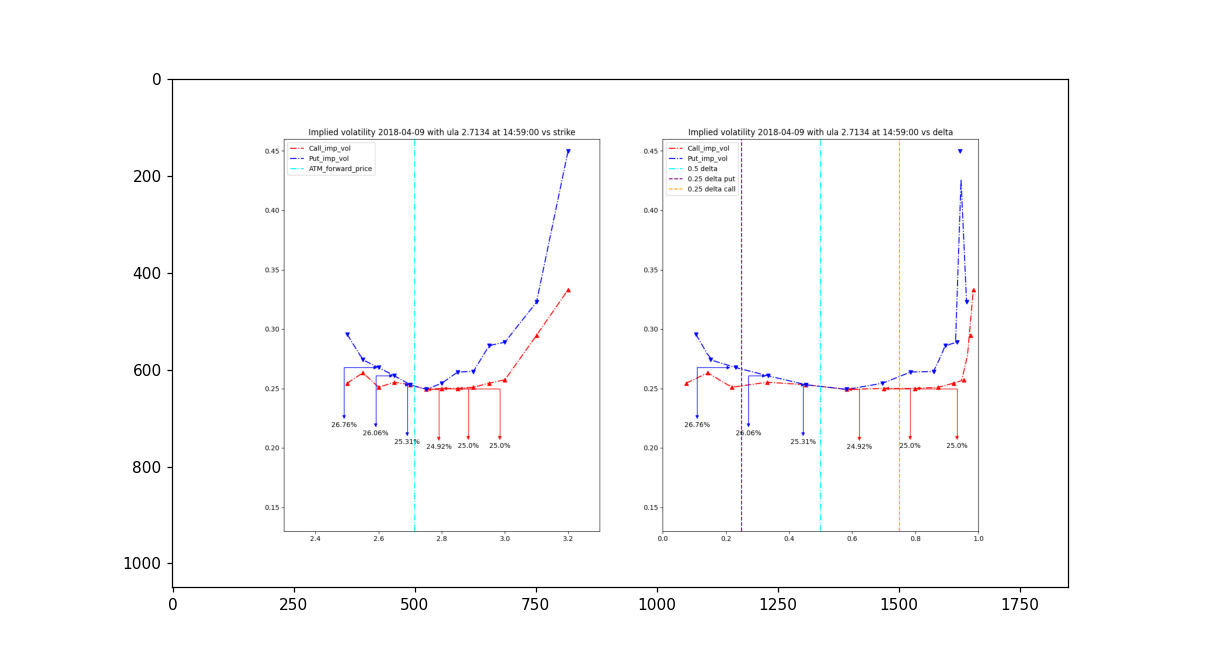

In [92]:
# Left: Implied volatiltiy 2018-04-09 with ula 2.7134 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-09 with ula 2.7134 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\6_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


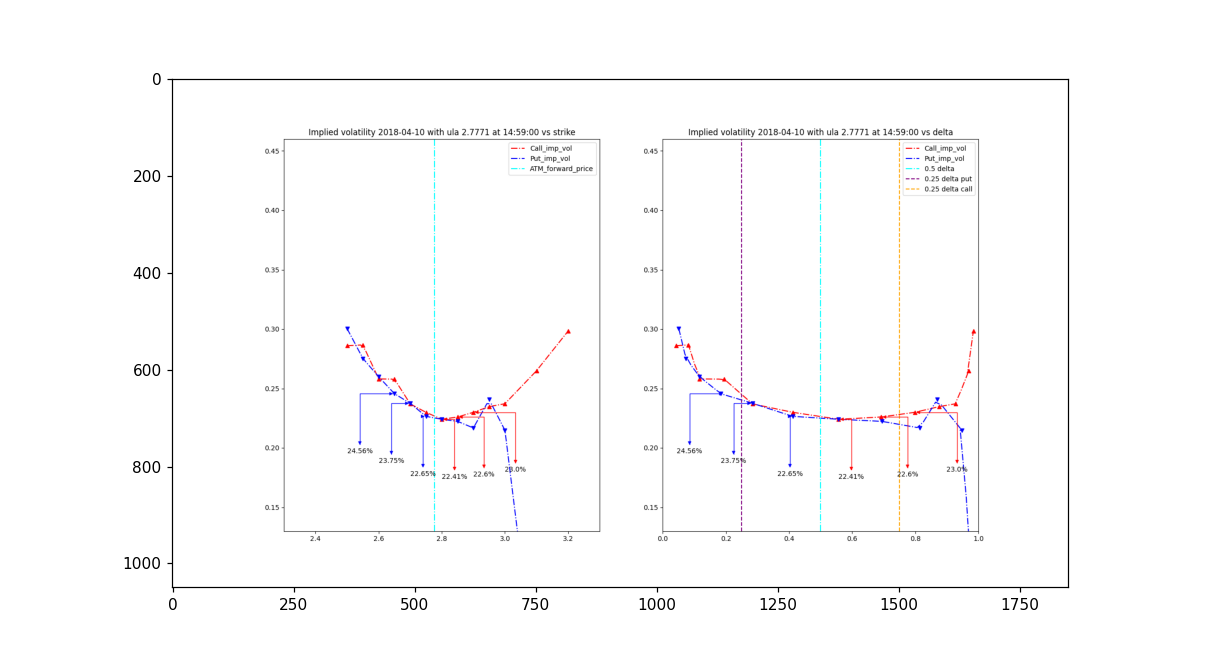

In [93]:
# Left: Implied volatiltiy 2018-04-10 with ula 2.7771 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-10 with ula 2.7771 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\7_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


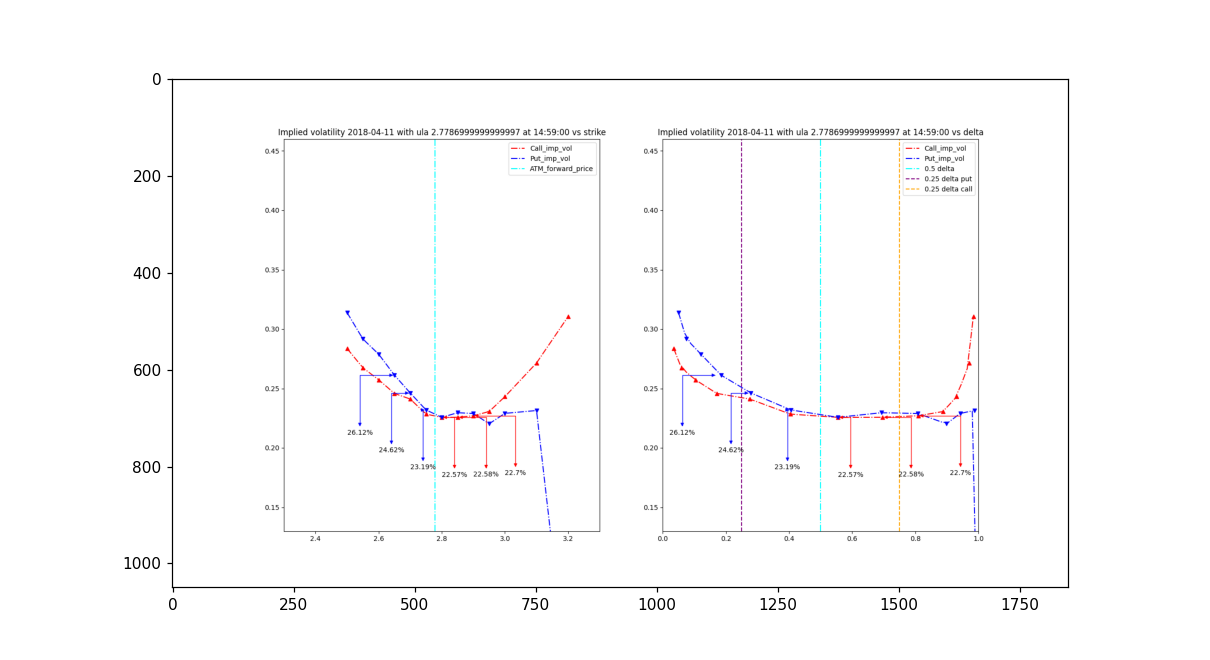

In [94]:
# Left: Implied volatiltiy 2018-04-11 with ula 2.7787 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-11 with ula 2.7787 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\8_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


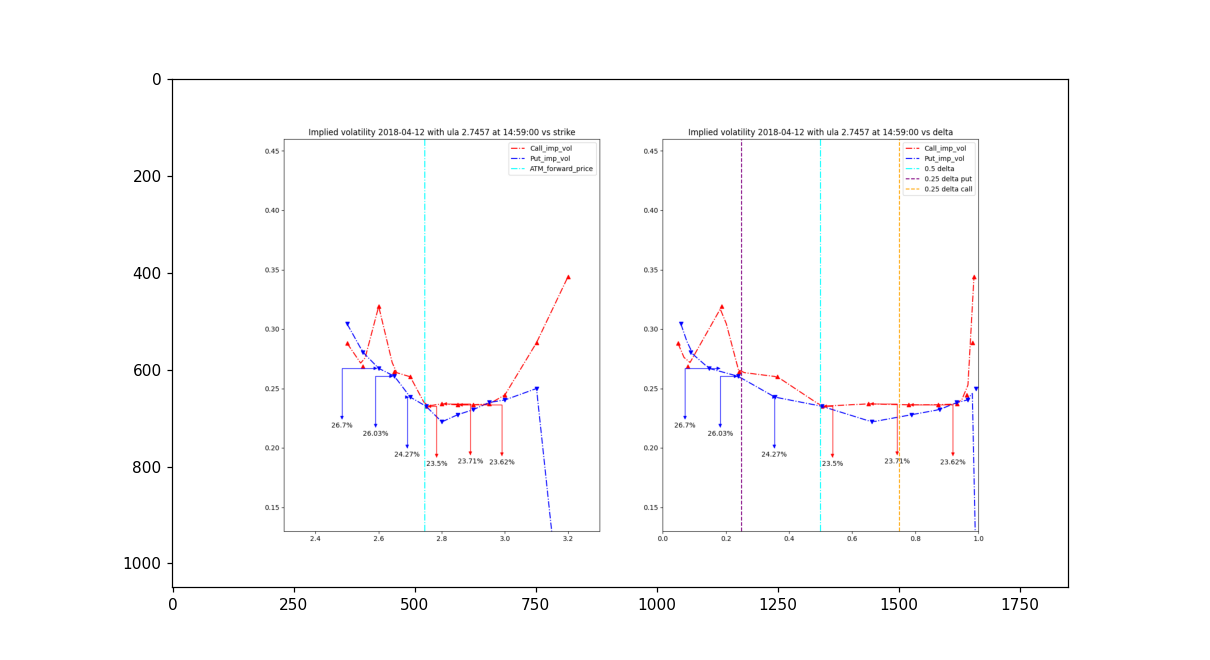

In [95]:
# Left: Implied volatiltiy 2018-04-12 with ula 2.7457 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-12 with ula 2.7457 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\9_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


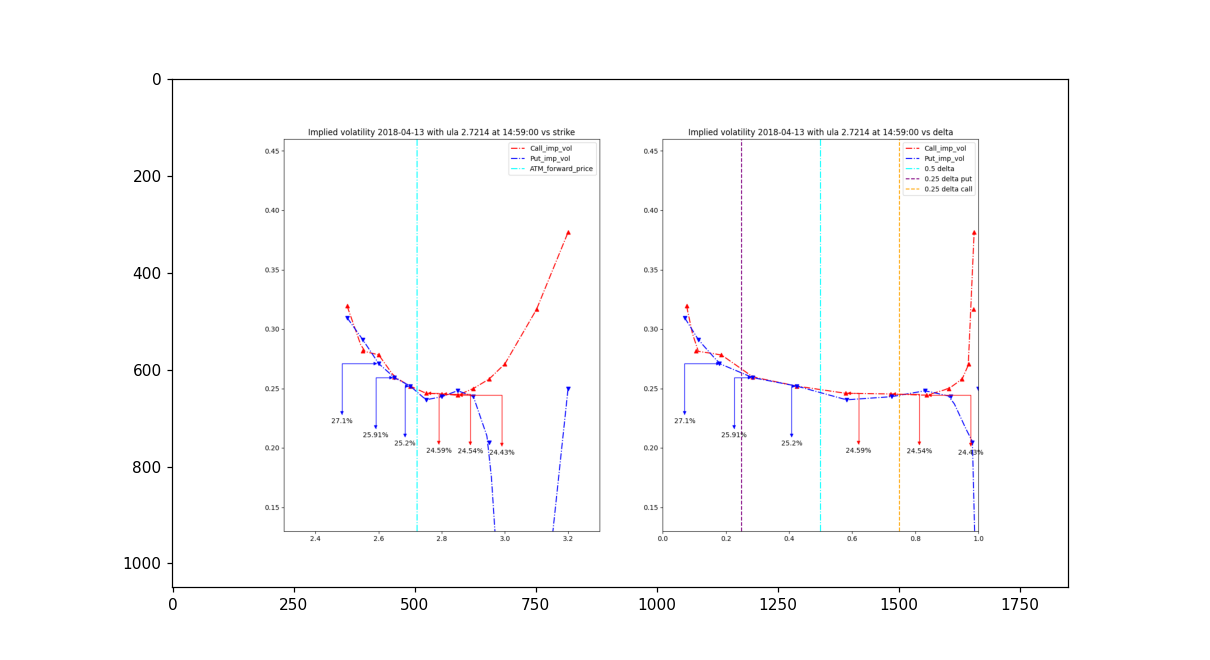

In [96]:
# Left: Implied volatiltiy 2018-04-13 with ula 2.7214 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-13 with ula 2.7214 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\10_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


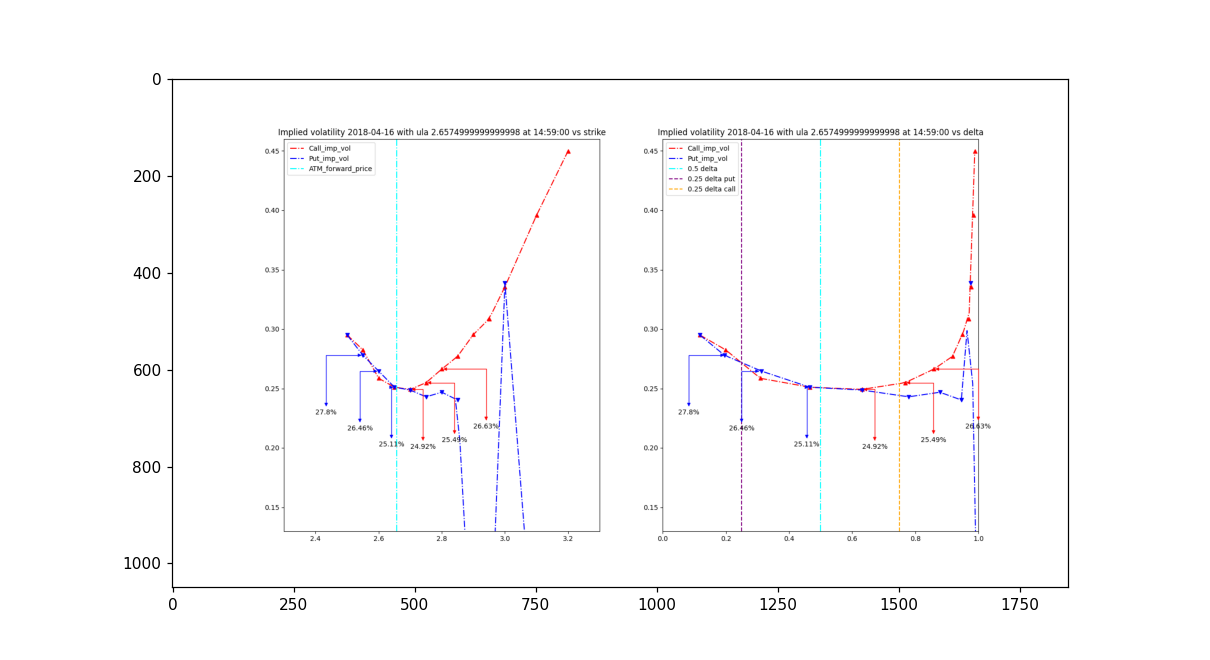

In [97]:
# Left: Implied volatiltiy 2018-04-12 with ula 2.6575 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-12 with ula 2.6575 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\11_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


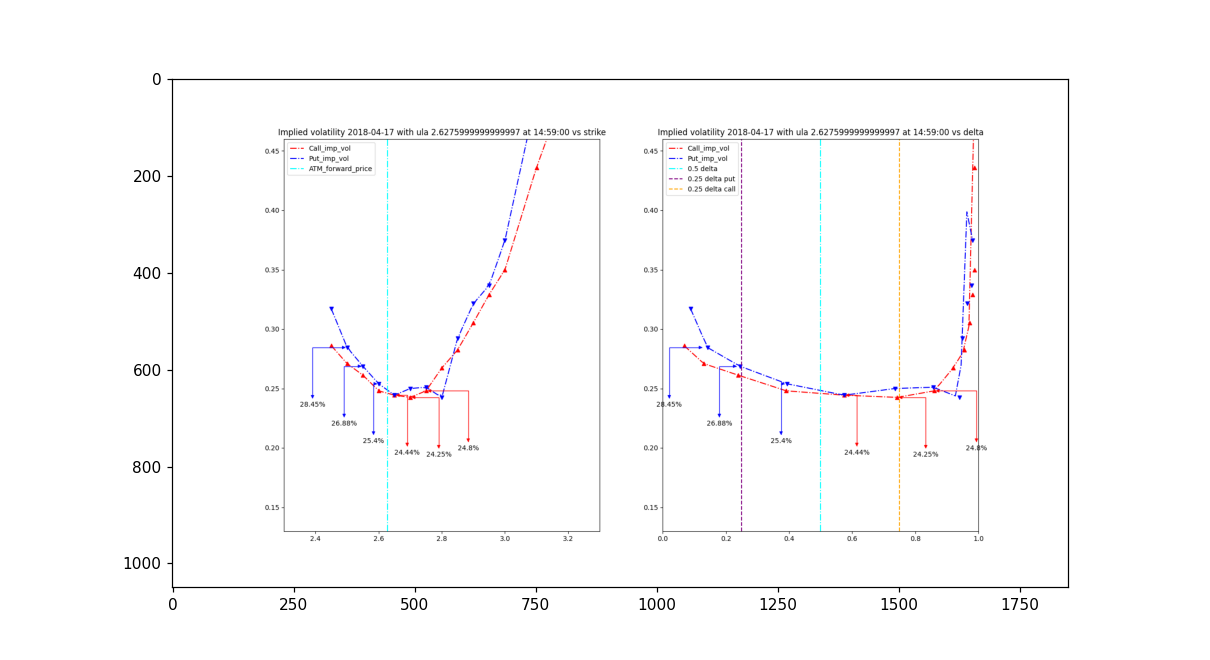

In [99]:
# Left: Implied volatiltiy 2018-04-17 with ula 2.6276 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-17 with ula 2.6276 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\12_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


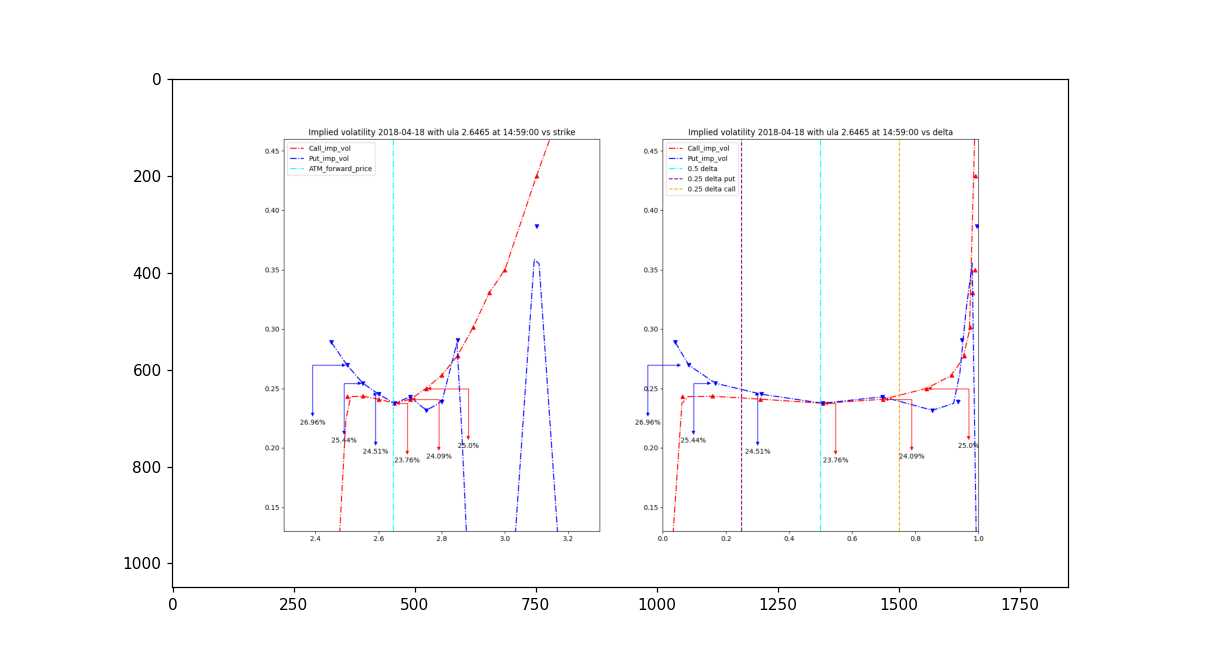

In [100]:
# Left: Implied volatiltiy 2018-04-18 with ula 2.6465 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-18 with ula 2.6465 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\13_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


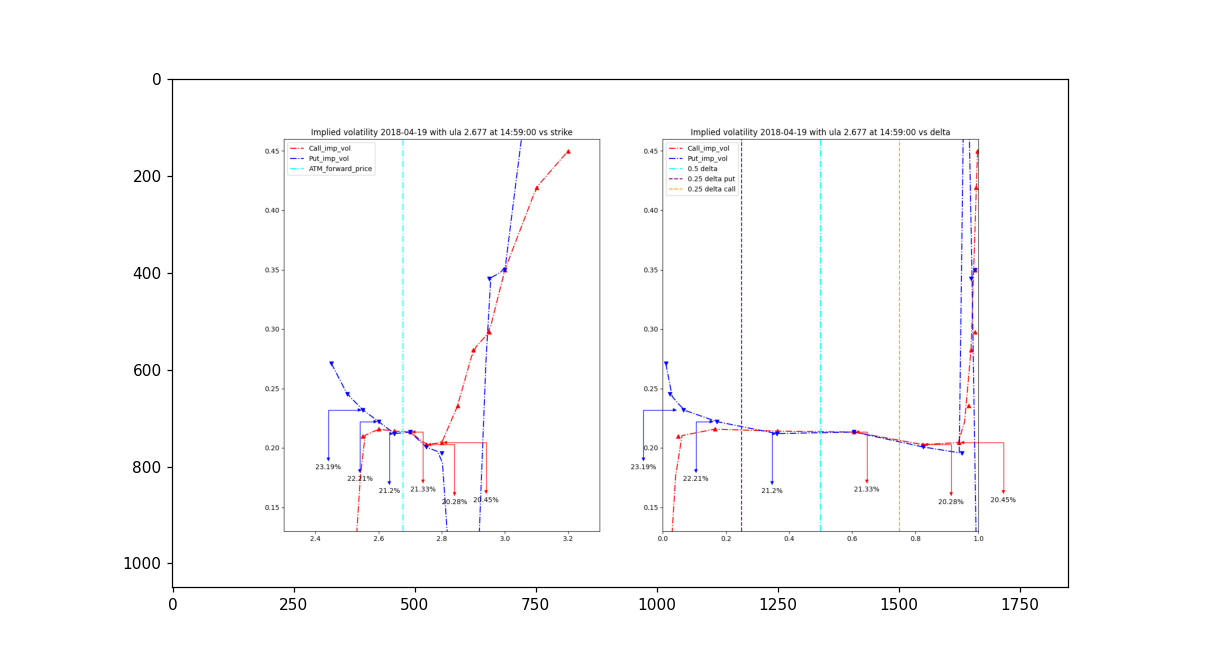

In [101]:
# Left: Implied volatiltiy 2018-04-19 with ula 2.677 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-19 with ula 2.677 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\14_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


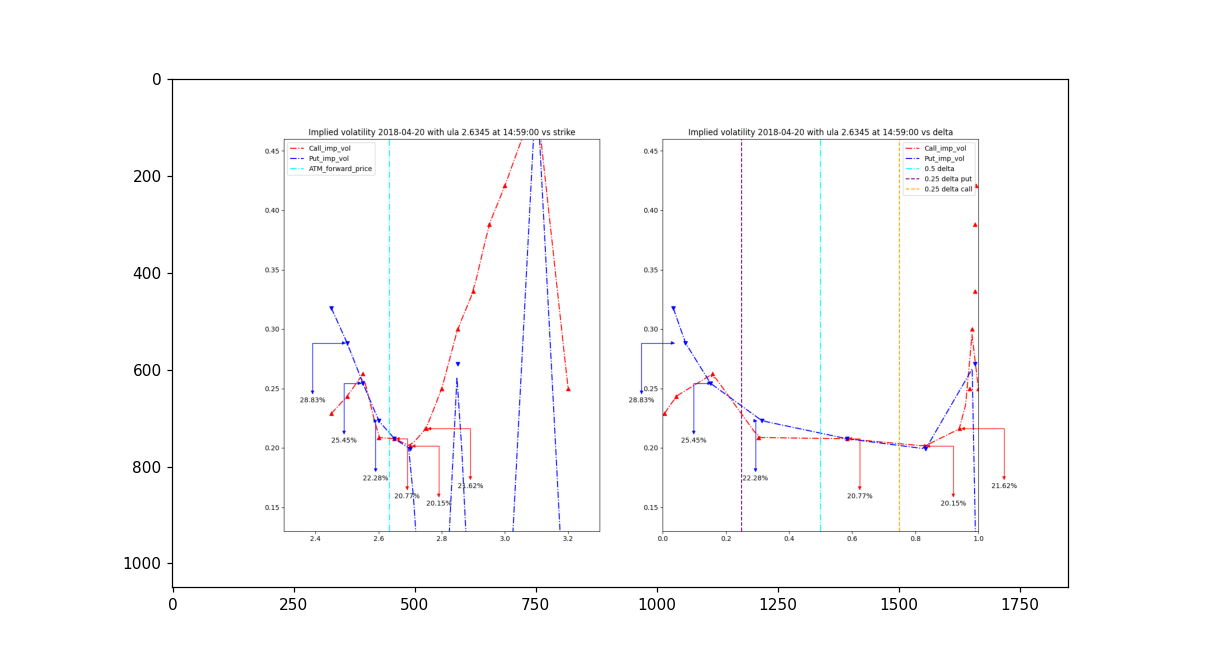

In [102]:
# Left: Implied volatiltiy 2018-04-20 with ula 2.6345 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-20 with ula 2.6345 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\15_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


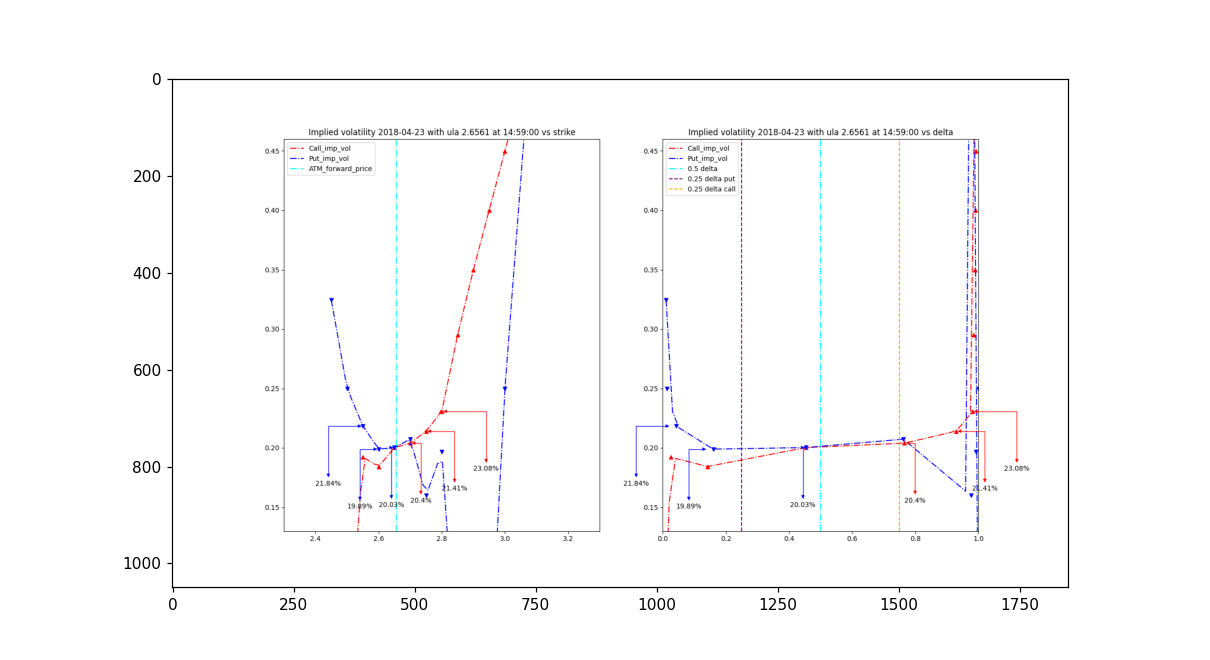

In [104]:
# Left: Implied volatiltiy 2018-04-23 with ula 2.6561 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-23 with ula 2.6561 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\16_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


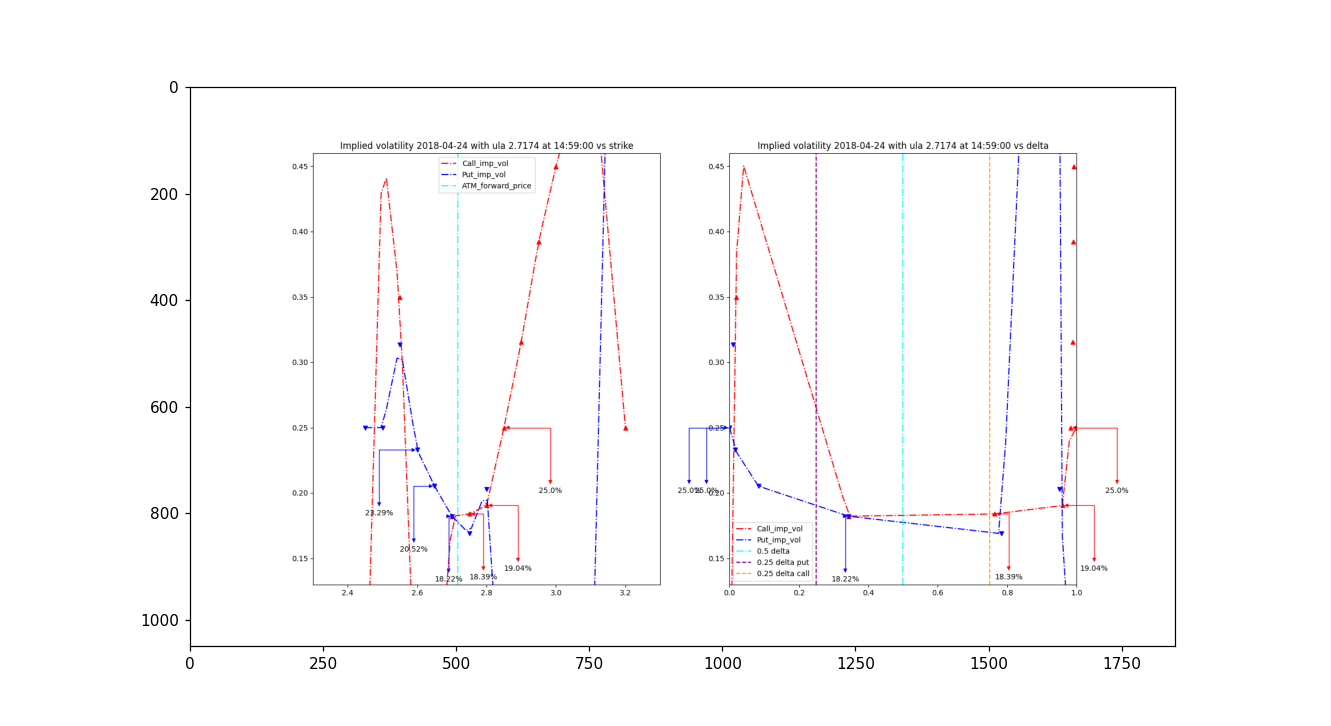

In [105]:
# Left: Implied volatiltiy 2018-04-24 with ula 2.7174 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-24 with ula 2.7174 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\17_Features.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


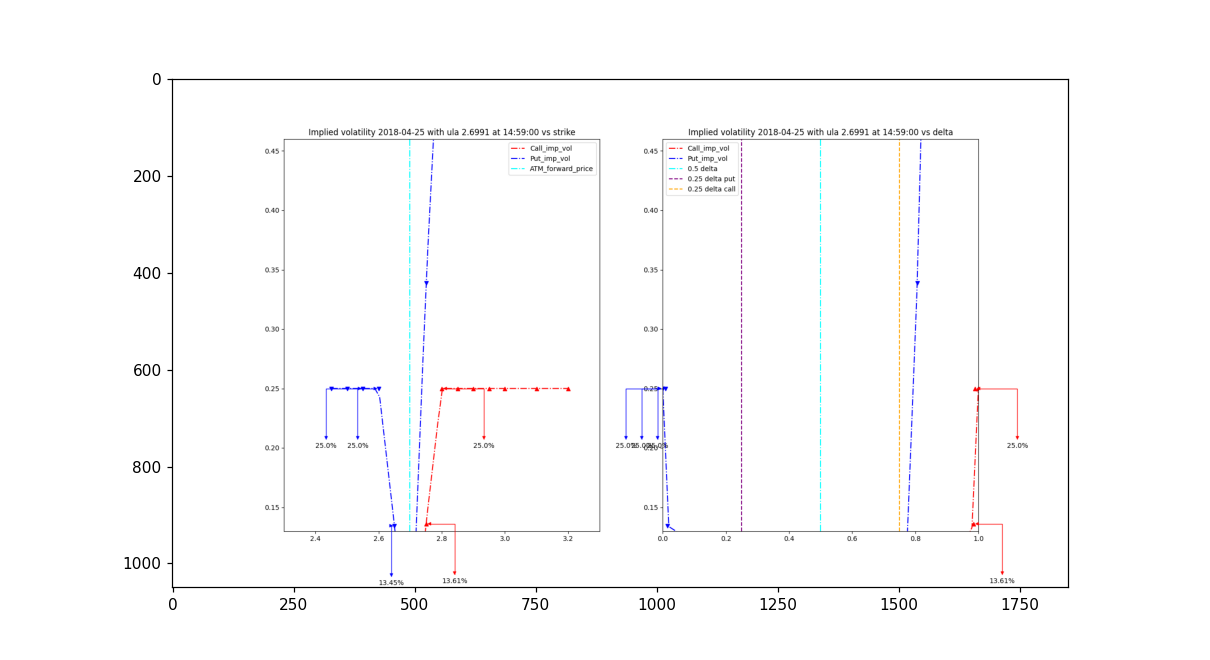

In [106]:
# Left: Implied volatiltiy 2018-04-25 with ula 2.6991 at 14:59:00 vs strike
# Right: Implied volatiltiy 2018-04-25 with ula 2.6991 at 14:59:00 vs delta

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\18_Features.png')
plt.imshow(image)
plt.show()

### Plot the Skew, Kurtosis, and ATM VOL based on Delta 10, Delta 25, and Delta 50 for four expiration dates of every trading dates from Jan 2016 to April 2023

In [50]:
# print(f'Skew_25 with length {len(Skew_25[0])} is {Skew_25} \n')
# print(f'Skew_10 with length {len(Skew_10[0])} is {Skew_10} \n')
# print(f'Kur_25 with length {len(Kur_25[0])} is {Kur_25} \n')
# print(f'Kur_10 with length {len(Kur_10[0])} is {Kur_10} \n')
# print(f'A is with length {len(A[0])} {A} \n')
#
# # Plotting the data
# color_plate = ['pink', 'c', 'sandybrown', 'y', 'mediumseagreen']
# five_features = [Skew_25, Skew_10, Kur_25, Kur_10, A]
# Title = ['Skew_25D', 'Skew_10D', 'Kurtosis_25D', 'Kurtosis_10D', "ATMVOL"]
#
# for feature in five_features:
#     index = five_features.index(feature)
#     fig, ax = plt.subplots()
#     for count in range(len(feature)):
#         print(f'{Title[index]}_{count + 1} has length: {len(feature[count])}')
#         plot_inter_all([i for i in range(1, len(feature[count]) + 1)], feature[count], color_plate[count], count)
#     plt.title(f'{Title[index]} vs. Time')
#
#     ax.set_xticklabels(['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'])
#     plt.legend()
#     fig = plt.gcf()
#     fig.set_size_inches(18.5, 10.5)
#
#     # Save the plot into local with corresponding feature names
#     plt.savefig(f'div_features_NoLast4_{Title[index]}.png')
#     plt.clf()

### a. All trading dates excluding dividends data

<IPython.core.display.Javascript object>


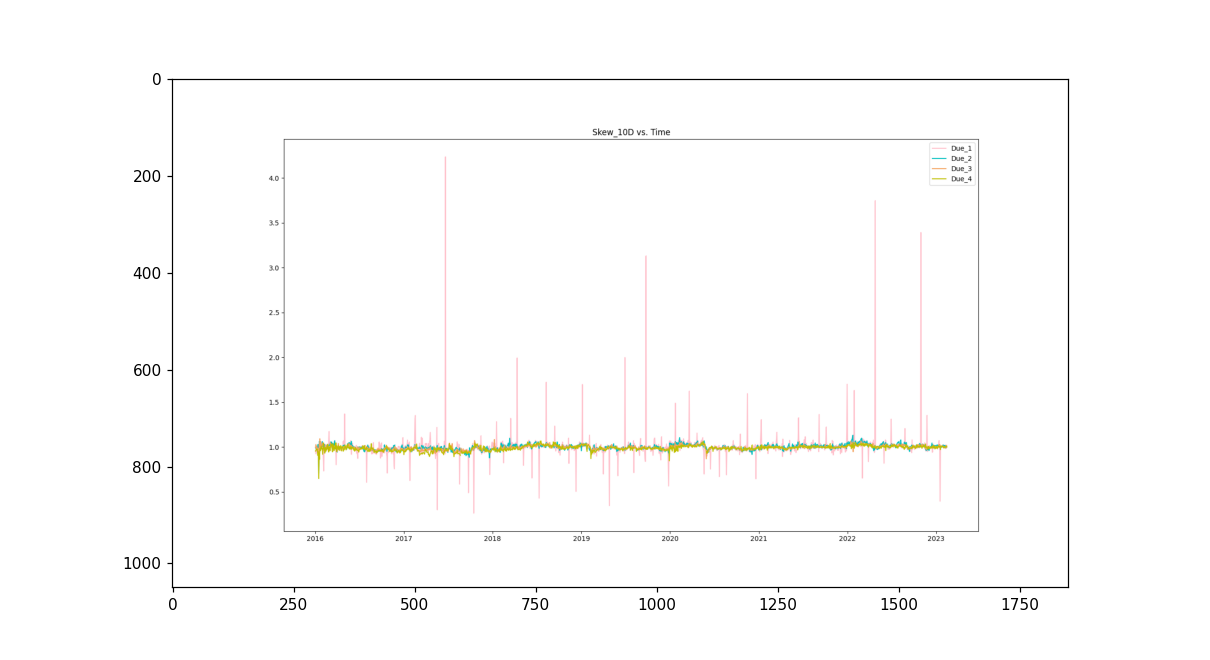

In [114]:
# Skew Calculated by 10 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\features_OG_Skew_10D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


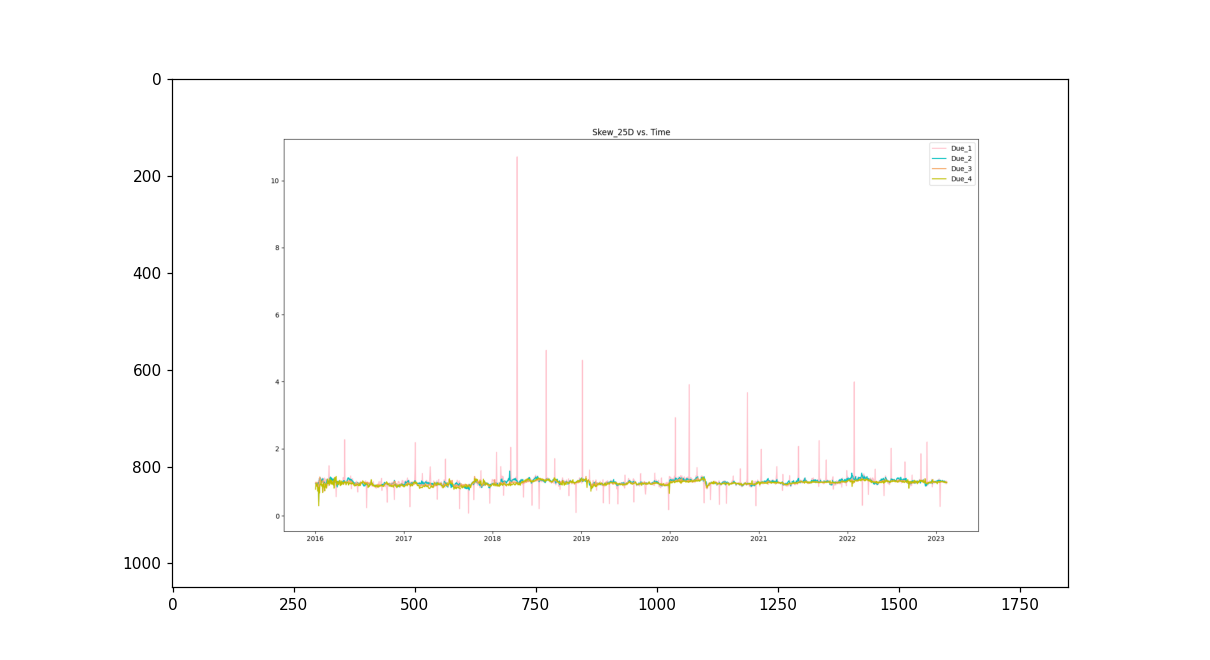

In [117]:
# Skew Calculated by 25 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\features_OG_Skew_25D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


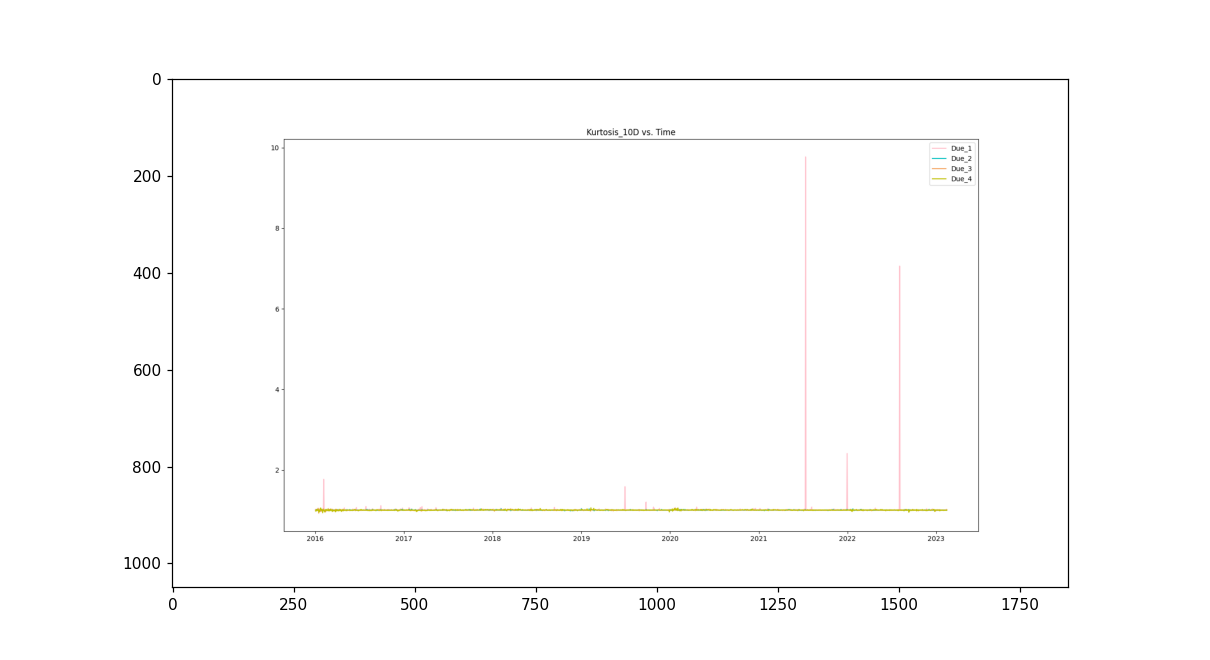

In [118]:
# Kurtosis Calculated by 10 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\features_OG_Kurtosis_10D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


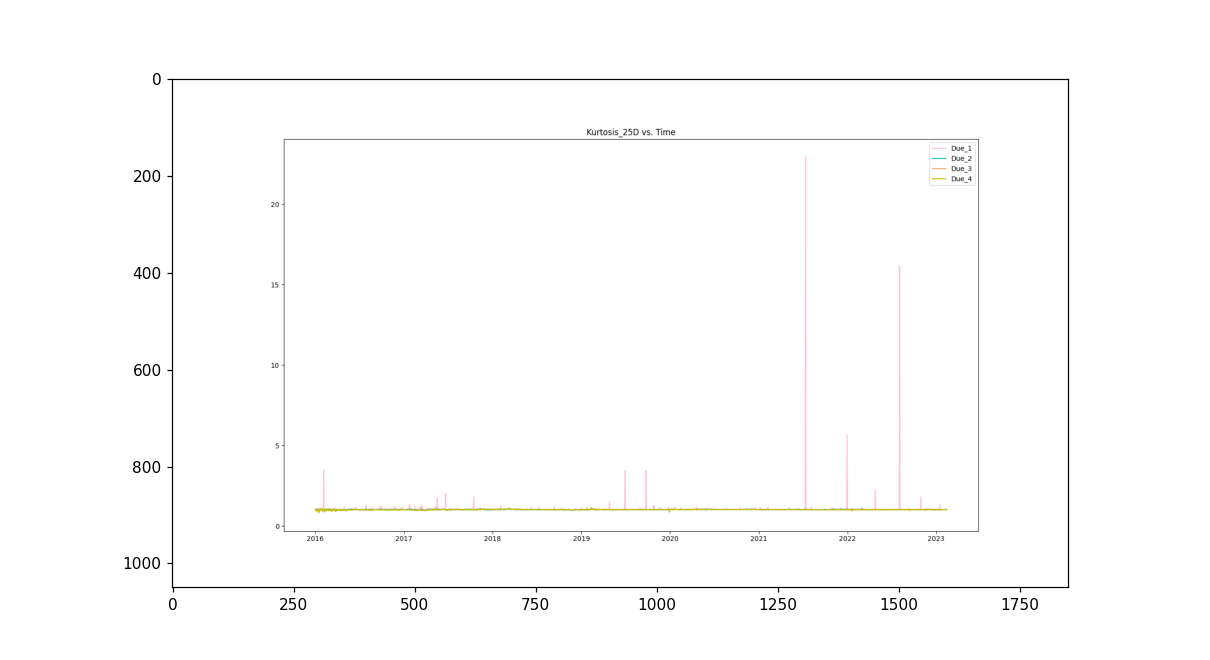

In [119]:
# Kurtosis Calculated by 25 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\features_OG_Kurtosis_25D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


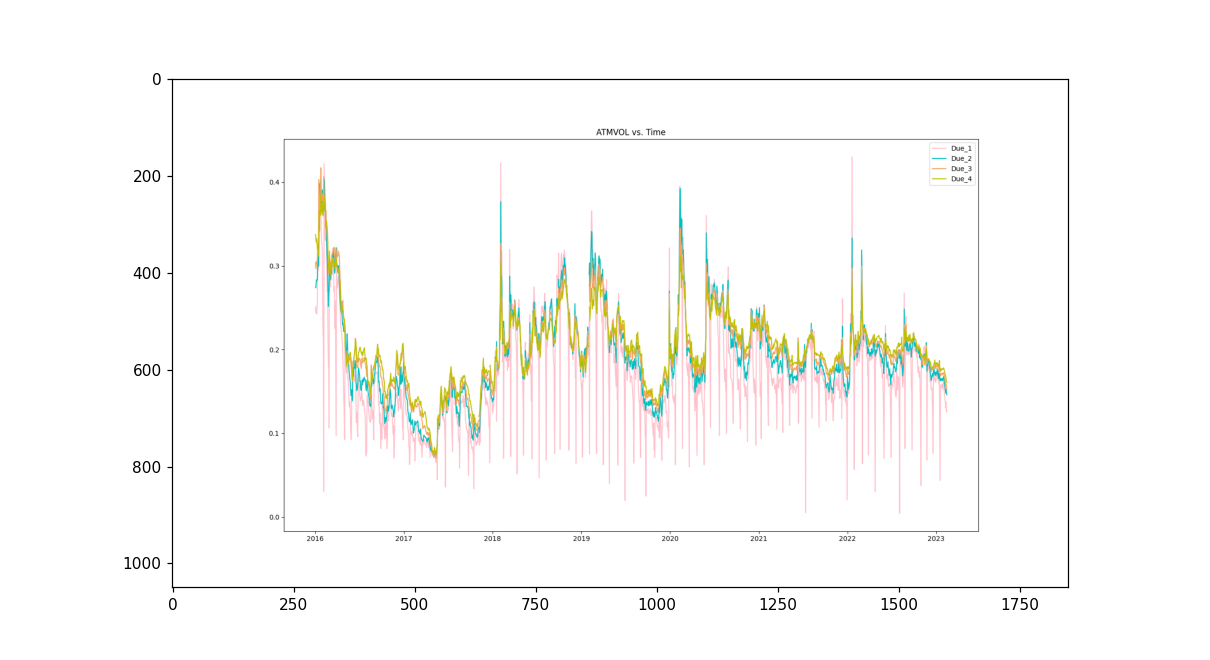

In [120]:
# ATM VOL Calculated by 50 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\features_OG_ATMVOL.png')
plt.imshow(image)
plt.show()

### b. Excluding the last four dates before the expiration dates while excluding dividends data

<IPython.core.display.Javascript object>


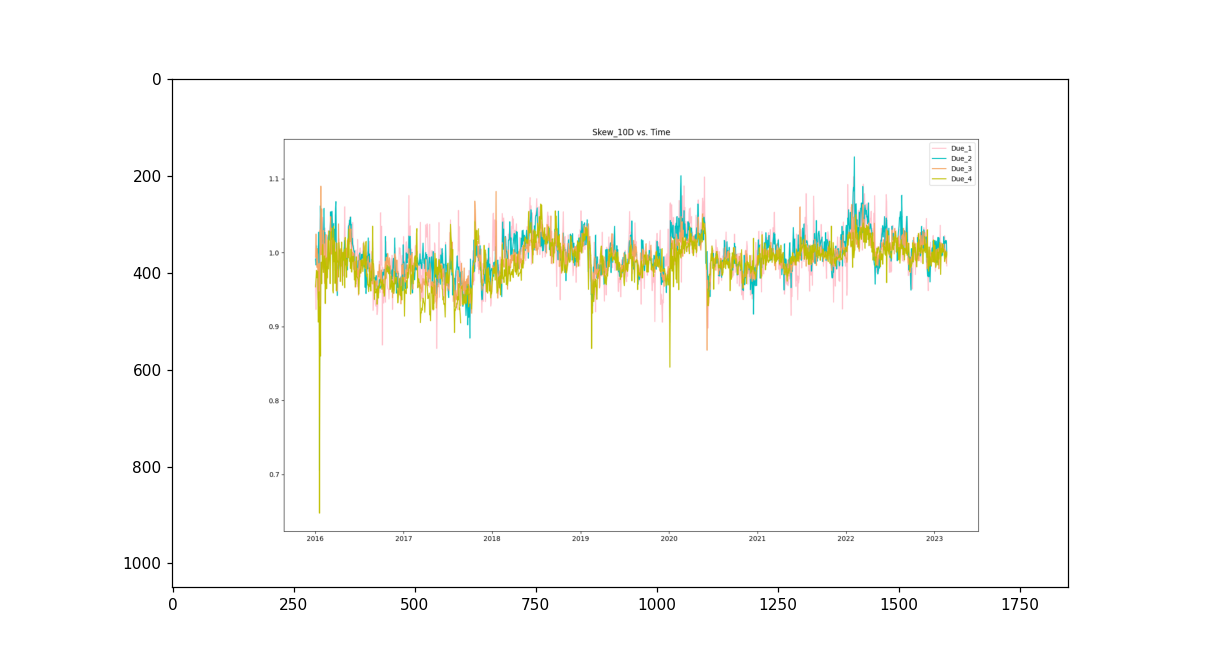

In [121]:
# Skew Calculated by 10 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\features_NoLast4_Skew_10D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


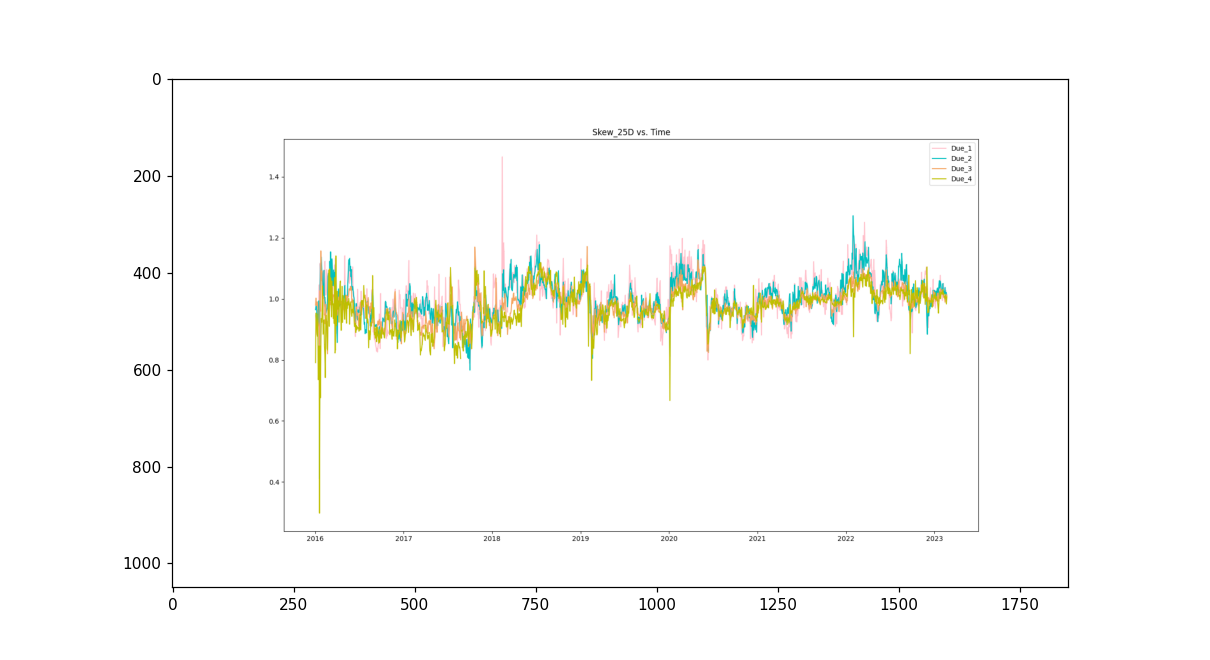

In [122]:
# Skew Calculated by 25 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\features_NoLast4_Skew_25D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


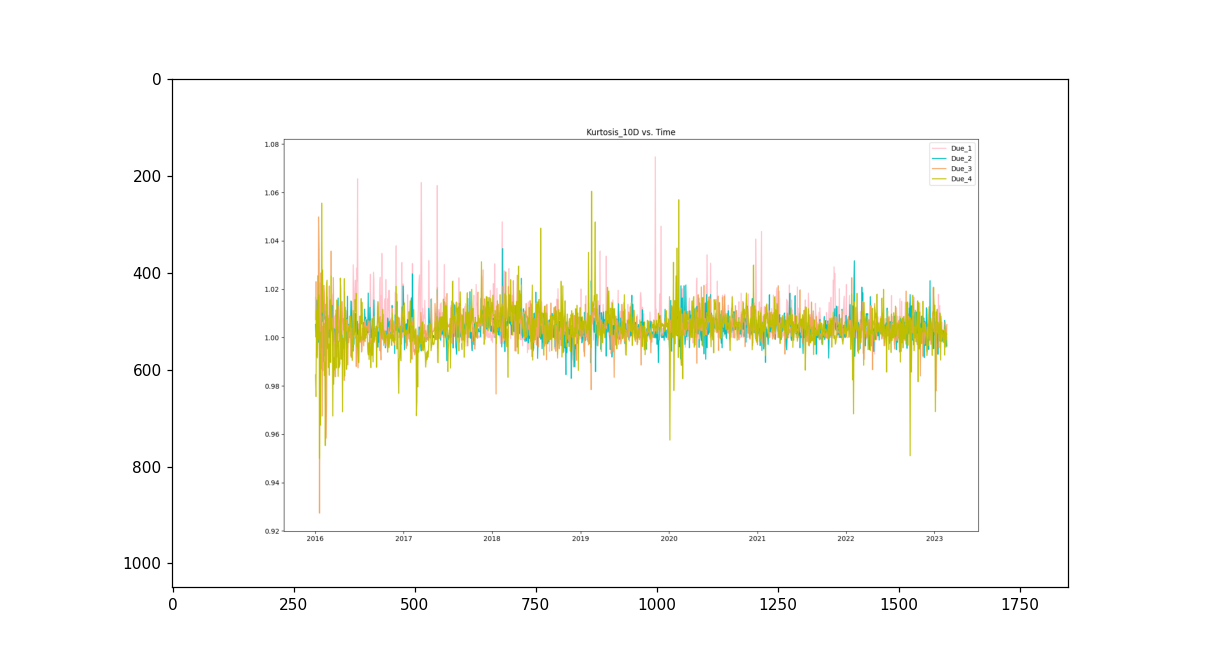

In [123]:
# Kurtosis Calculated by 10 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\features_NoLast4_Kurtosis_10D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


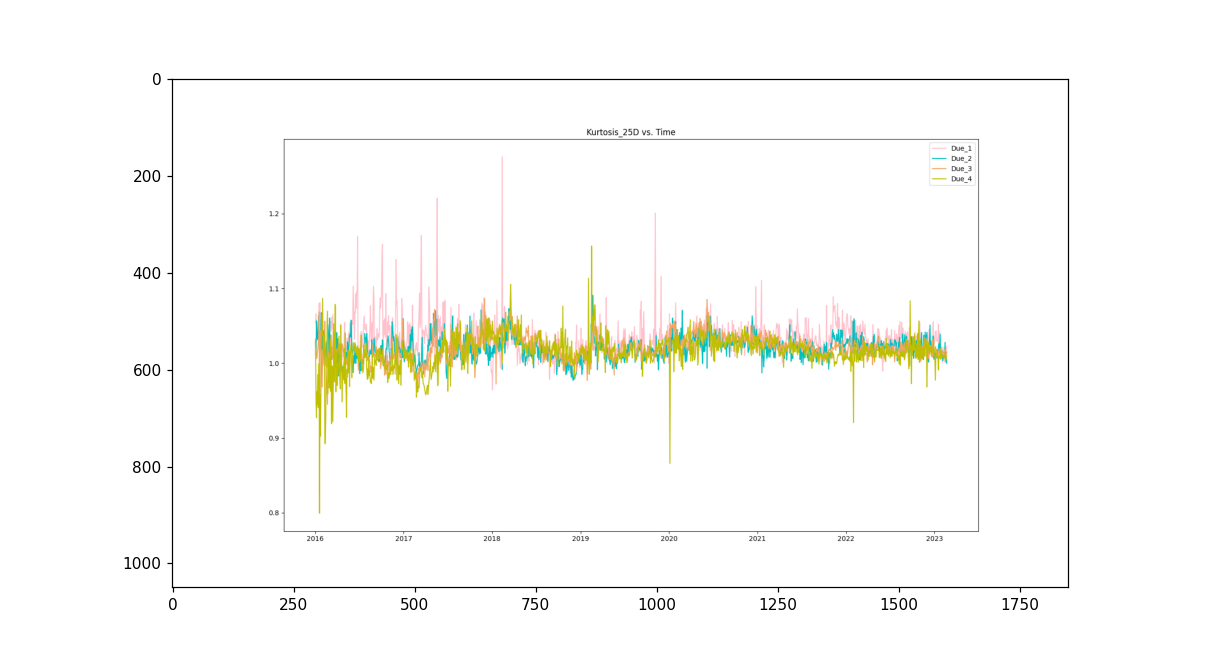

In [124]:
# Kurtosis Calculated by 25 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\features_NoLast4_Kurtosis_25D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


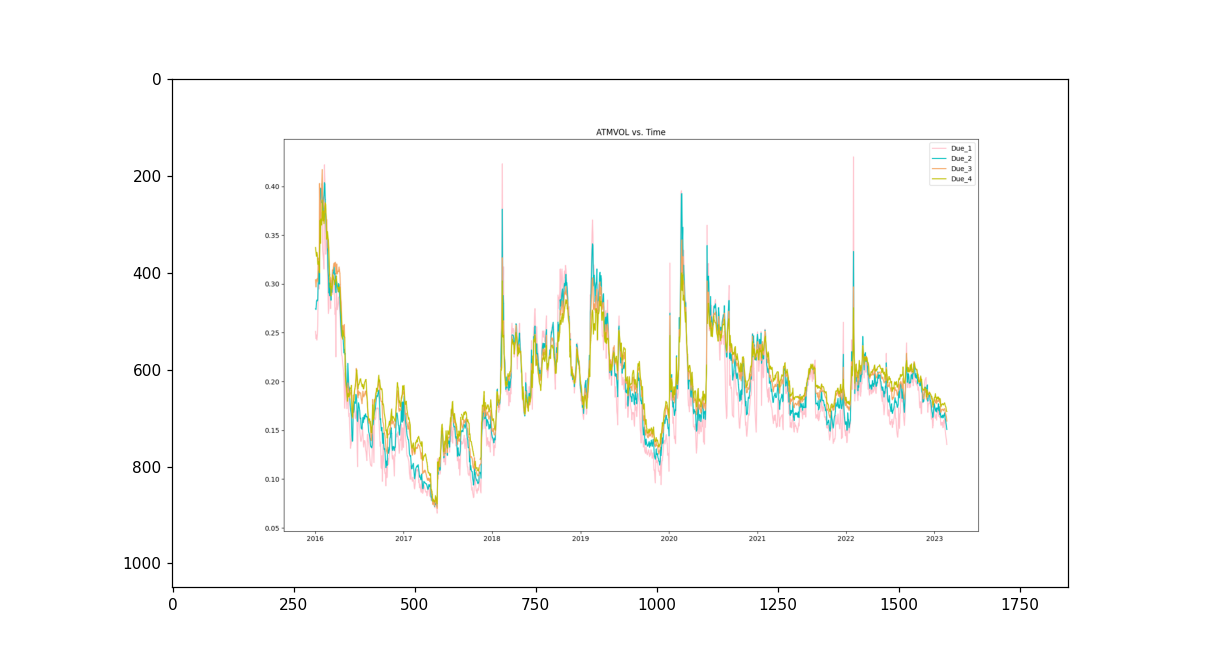

In [125]:
# ATMVOL Calculated by 50 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\features_NoLast4_ATMVOL.png')
plt.imshow(image)
plt.show()

### c. All trading dates including dividends data

<IPython.core.display.Javascript object>


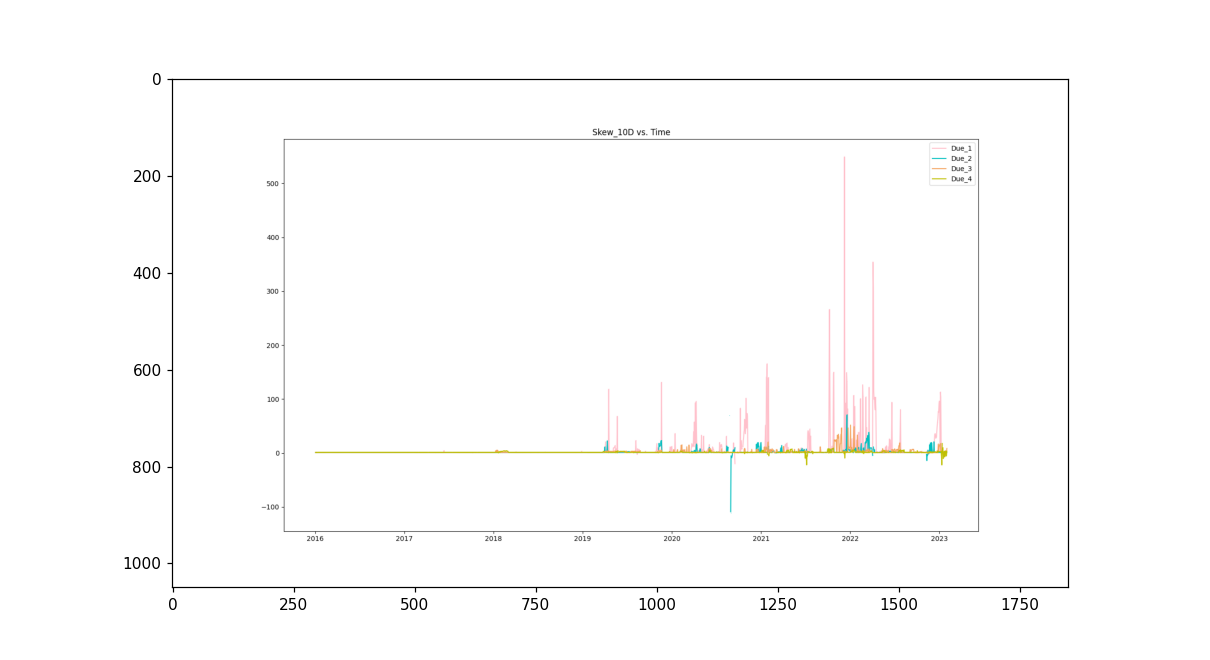

In [126]:
# Skew Calculated by 10 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\div_features_all_Skew_10D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


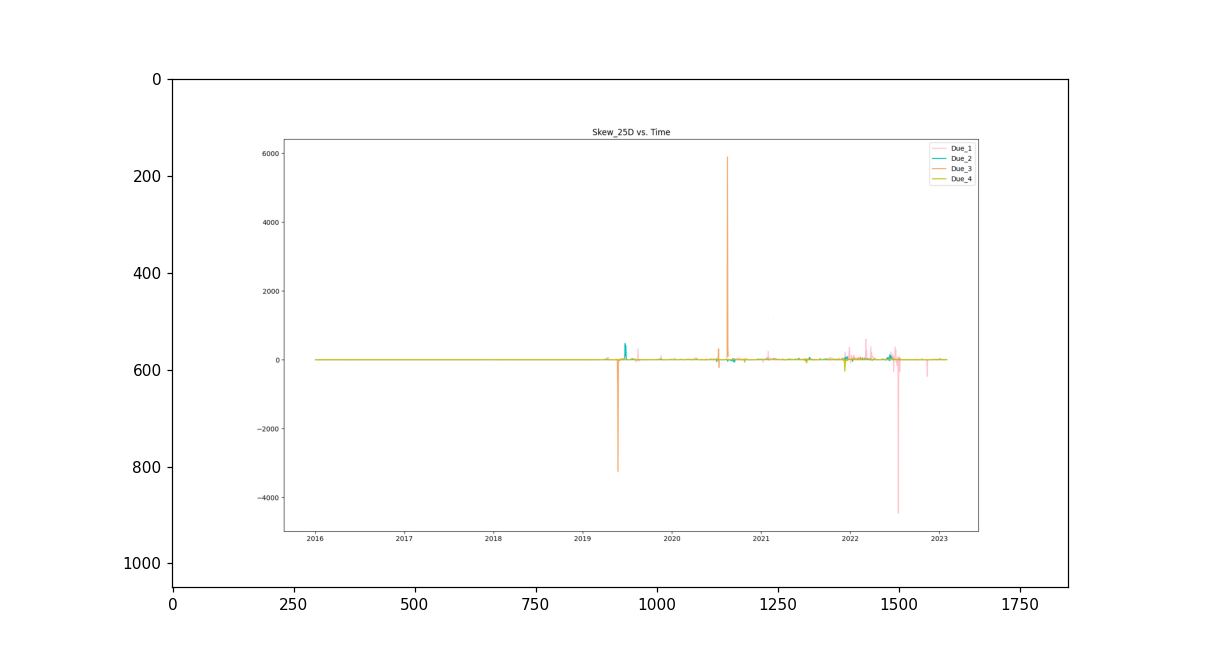

In [127]:
# Skew Calculated by 25 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\div_features_all_Skew_25D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


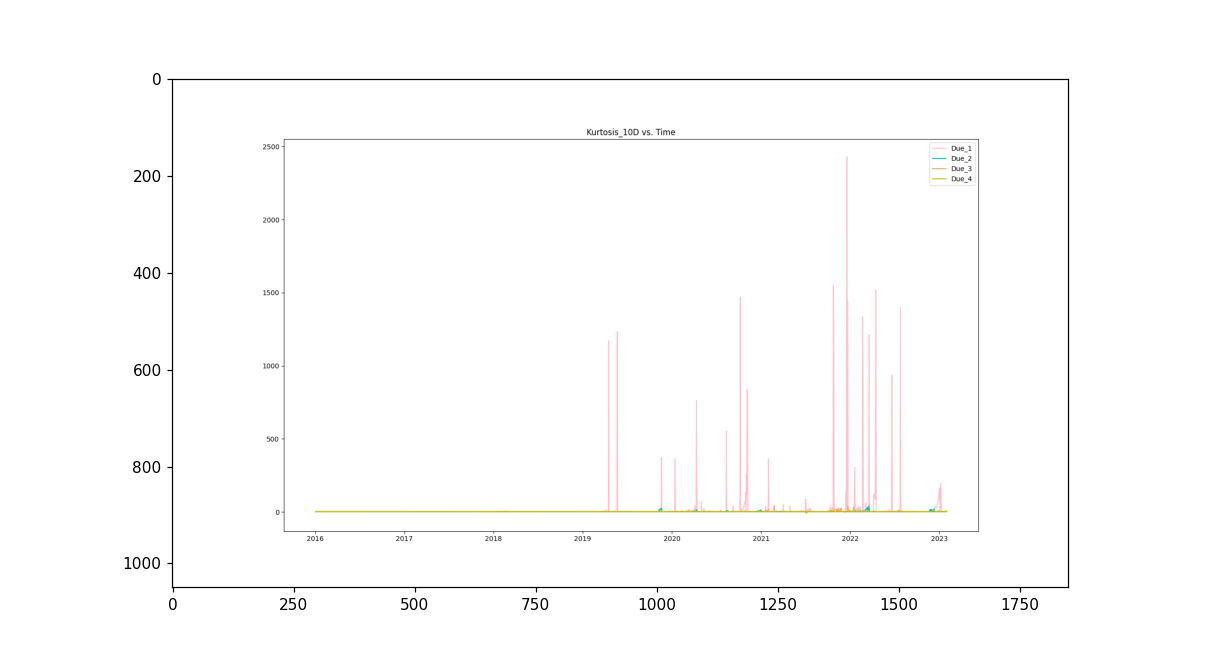

In [128]:
# Kurtosis Calculated by 10 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\div_features_all_Kurtosis_10D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


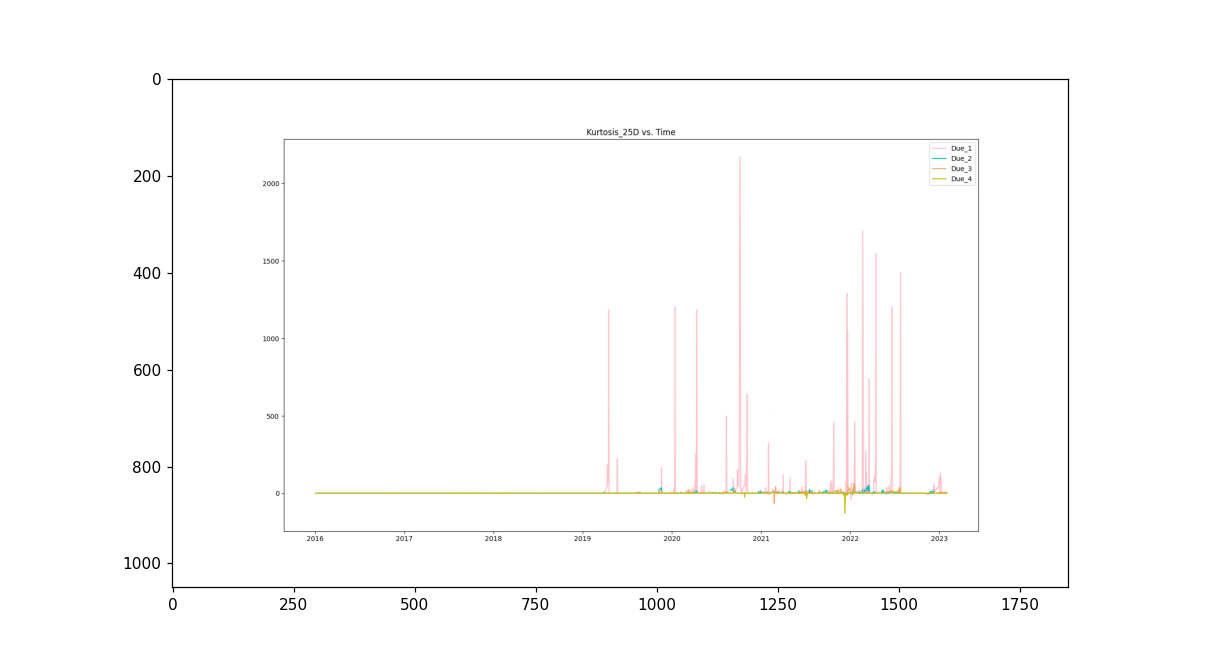

In [129]:
# Kurtosis Calculated by 25 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\div_features_all_Kurtosis_25D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


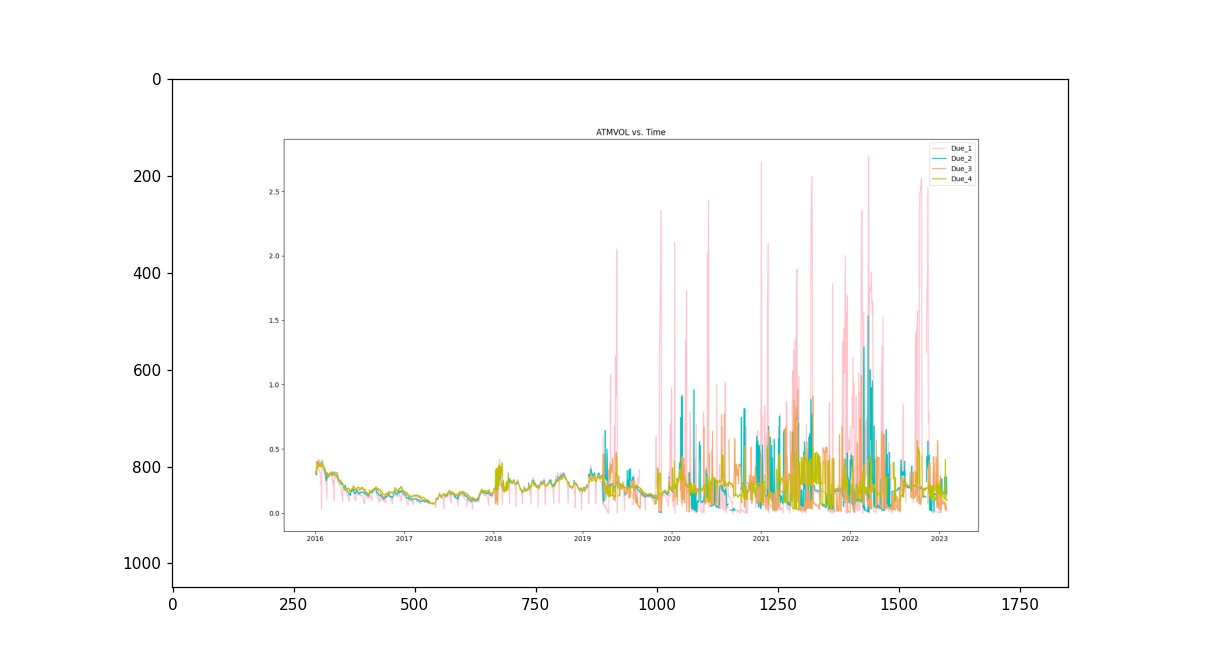

In [131]:
# ATMVOL Calculated by 10 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\div_features_all_ATMVOL.png')
plt.imshow(image)
plt.show()

### d. Excluding the last four dates before the expiration dates while including dividends data

<IPython.core.display.Javascript object>


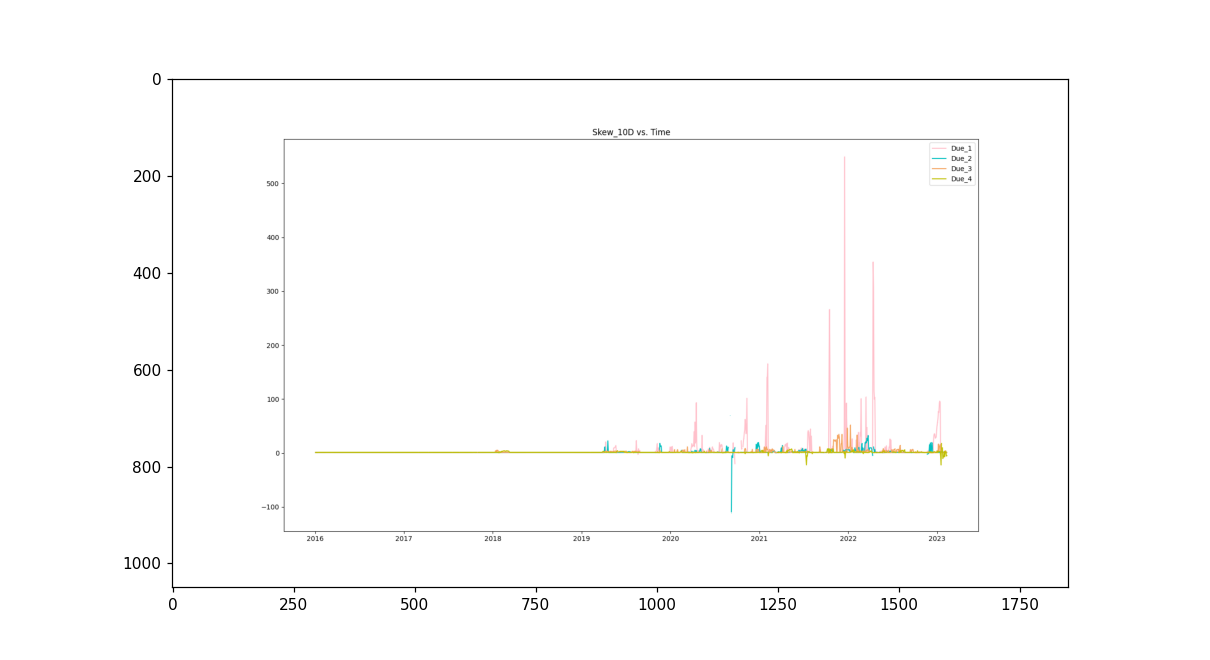

In [132]:
# Skew Calculated by 10 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\div_features_NoLast4_Skew_10D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


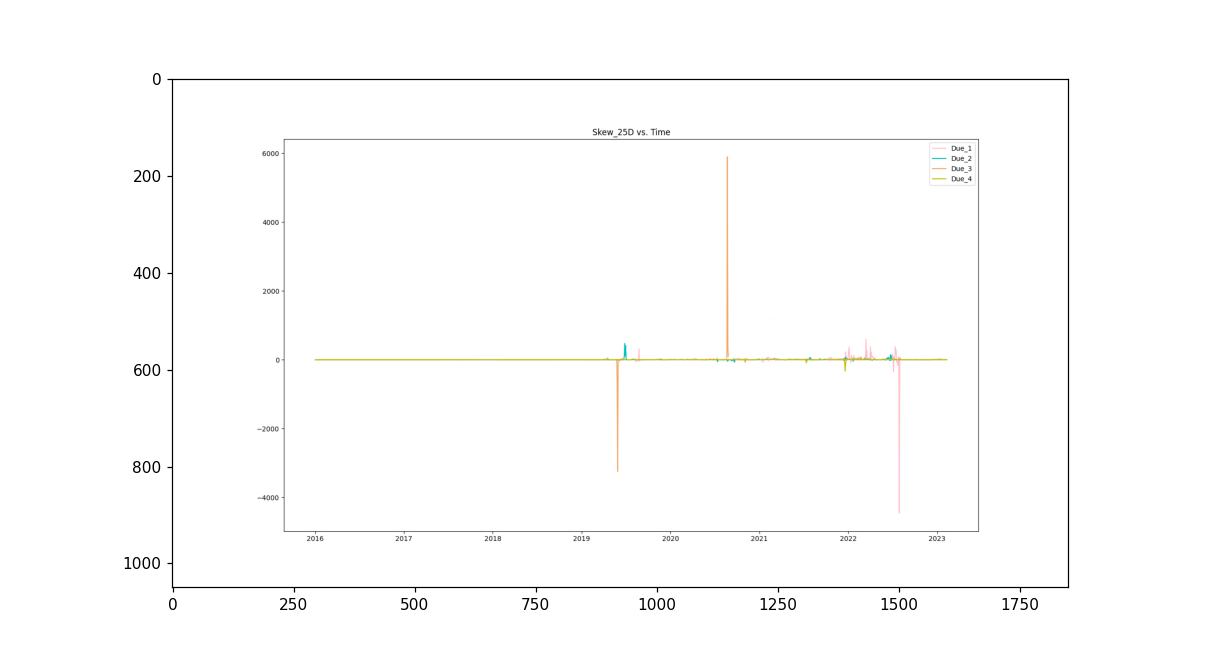

In [133]:
# Skew Calculated by 25 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\div_features_NoLast4_Skew_25D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


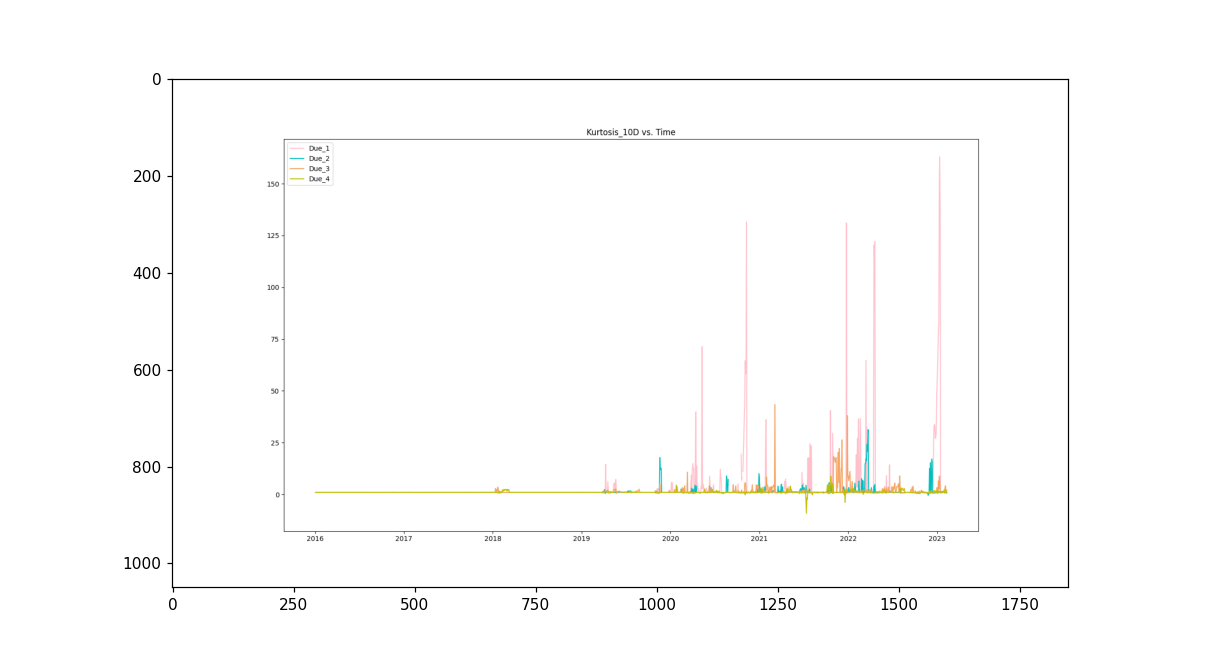

In [134]:
# Kurtosis Calculated by 10 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\div_features_NoLast4_Kurtosis_10D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


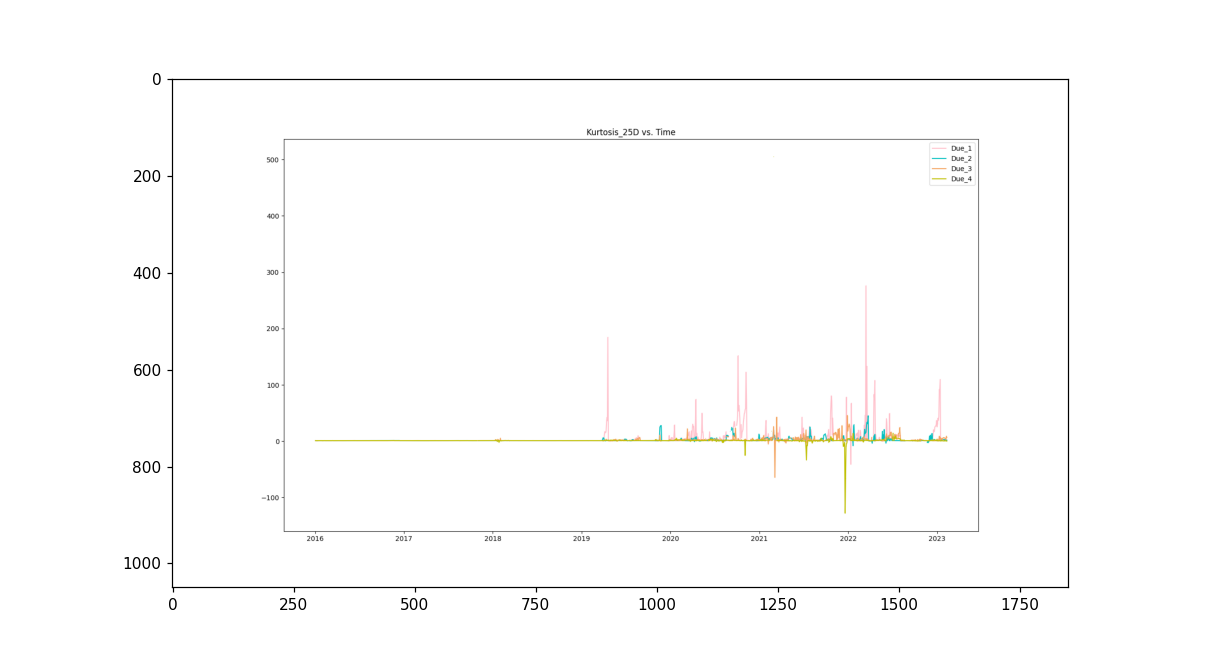

In [135]:
# Kurtosis Calculated by 25 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\div_features_NoLast4_Kurtosis_25D.png')
plt.imshow(image)
plt.show()

<IPython.core.display.Javascript object>


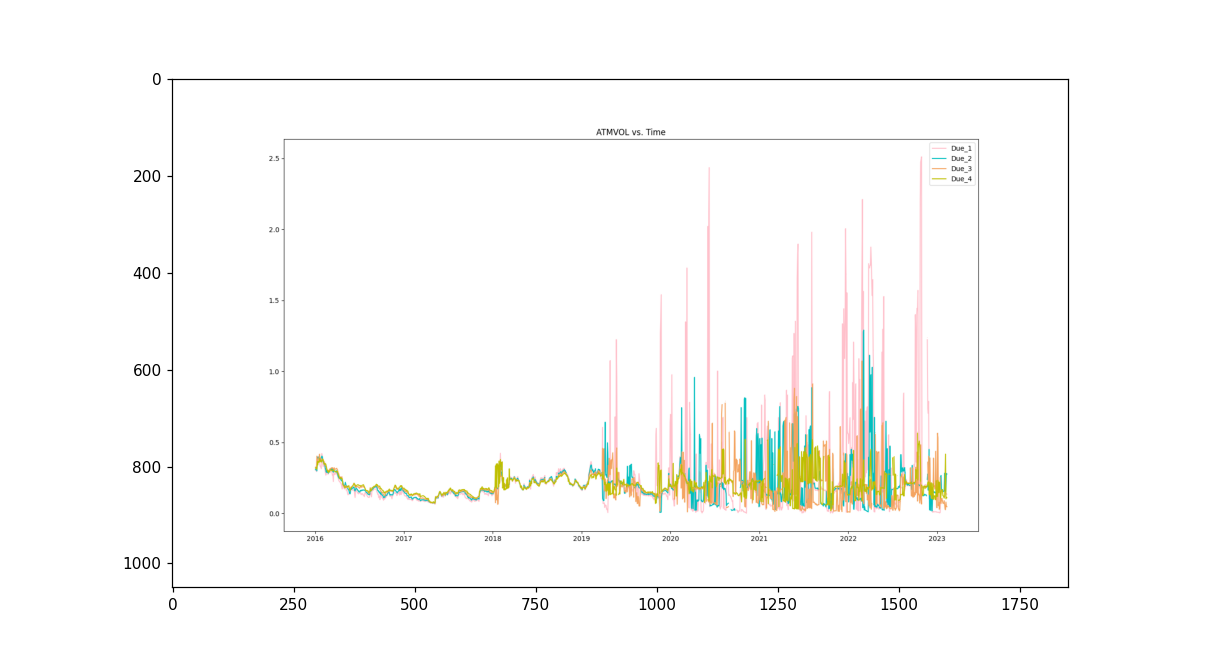

In [136]:
# ATMVOL Calculated by 10 Delta vs. Time

%matplotlib notebook
plt.figure(figsize=(11,6))
image = mpimg.imread(r'C:\Users\ps\PycharmProjects\pythonProject\div_features_NoLast4_ATMVOL.png')
plt.imshow(image)
plt.show()

# -

### Load Skew, Kurtosis, and ATMVOL data

In [53]:
SKA = pd.read_csv(r"C:\Users\ps\PycharmProjects\pythonProject\final_feature_df.csv")
SKA = SKA.drop(['Unnamed: 0', ], axis=1)

In [54]:
SKA

Skew_25D_due_1  Skew_25D_due_2  Skew_25D_due_3  Skew_25D_due_4   
0           0.923372        0.917767        0.927259        0.735207  \
1           0.973510        0.993199        0.912865        0.845397   
2           1.045948        0.938890        0.909002        0.834409   
3           0.720348        0.410439        0.739309        0.297780   
4           1.116059        1.034521        1.026676        0.845813   
...              ...             ...             ...             ...   
1766        1.060941        4.498897        2.759377        0.416769   
1767        1.078182        4.892385        2.175505        0.670168   
1768        1.035295        3.463797        5.957239       -1.204183   
1769        1.064209        3.705820        4.279739       -1.118657   
1770        1.103153        5.085588        3.691407        0.649716   

      Skew_10D_due_1  Skew_10D_due_2  Skew_10D_due_3  Skew_10D_due_4   
0           0.963420        0.999621        0.938486        0.906150  \
1           1.004114        1.027775        0.982202        0.937102   
2           1.002164        0.972231        0.985422        0.947021   
3           0.911925        0.705516        0.778188        0.647581   
4           1.042278        1.007374        1.030695        0.926662   
...              ...             ...             ...             ...   
1766        1.001664        1.031245        3.995141        1.105706   
1767        1.002012        1.037663        0.781567        3.330279   
1768        0.993350        0.629549        0.759907       -5.716870   
1769        0.981832        0.653986        0.748031       -5.036749   
1770        1.026680        1.023796        8.243231        3.541517   

      Kurtosis_25D_due_1  Kurtosis_25D_due_2  ...  Kurtosis_10D_due_1   
0               1.058835            1.044306  ...            1.012613  \
1               1.059419            1.063924  ...            1.025213   
2               1.080434            1.037002  ...            1.032194   
3               1.056589            0.976519  ...            1.000000   
4               1.080388            1.043265  ...            1.022564   
...                  ...                 ...  ...                 ...   
1766            1.043356            2.770801  ...            1.003817   
1767            1.034885            2.945717  ...            0.999710   
1768            1.036317            1.784922  ...            1.000000   
1769            1.053563            1.877534  ...            1.000000   
1770            1.053486            3.092985  ...            1.002354   

      Kurtosis_10D_due_2  Kurtosis_10D_due_3  Kurtosis_10D_due_4   
0               1.000000            1.004837            0.999150  \
1               0.998040            1.049898            1.007366   
2               1.007750            1.036293            1.017606   
3               1.000000            0.927339            0.949954   
4               0.988786            0.983888            0.993229   
...                  ...                 ...                 ...   
1766            1.013920            4.164542            0.907801   
1767            1.015045            1.269547            2.370663   
1768            0.731777            1.903851            0.996123   
1769            0.751844            1.856754            1.000000   
1770            1.018330            7.950657            2.492068   

      ATMVOL_due_1  ATMVOL_due_2  ATMVOL_due_3  ATMVOL_due_4   
0         0.305116      0.307941      0.326327      0.320228  \
1         0.312993      0.322863      0.318144      0.322979   
2         0.294845      0.326976      0.313965      0.319394   
3         0.344291      0.299801      0.402996      0.311452   
4         0.343662      0.373299      0.366315      0.365204   
...            ...           ...           ...           ...   
1766      0.146762      0.158250      0.026687      0.417975   
1767      0.143040      0.154476      0.080481      0.103108   
1768  

In [56]:
features

tradingday  C_Volume_1month  C_Turnover_1month  C_OpenInterest_1month   
0    2016-01-04            66383         33093135.0                 145347  \
1    2016-01-05           126907         58850594.0                 163306   
2    2016-01-06            86468         40493942.0                 166950   
3    2016-01-07            17171          6401139.0                 168476   
4    2016-01-08           130090         59087387.0                 187378   
...         ...              ...                ...                    ...   
1766 2023-04-10           497569        213781953.0                 740105   
1767 2023-04-11           553012        221623779.0                 765477   
1768 2023-04-12           492159        168743102.0                 801769   
1769 2023-04-13           625412        215611102.0                 765910   
1770 2023-04-14           652083        254970442.0                 748626   

      C_Volume_2month  C_Turnover_2month  C_OpenInterest_2month   
0                6460          3580664.0                  10652  \
1               12616          8137192.0                  14110   
2                5220          3058123.0                  15473   
3                2473          1248189.0                  16463   
4               23015         15454628.0                  25046   
...               ...                ...                    ...   
1766            49638         23625695.0                  90727   
1767            57252         27813556.0                 103933   
1768            68584         27398765.0                 118993   
1769            78532         28713435.0                 130943   
1770            93757         38409478.0                 138170   

      C_Volume_1quarter  C_Turnover_1quarter  C_OpenInterest_1quarter  ...   
0                 14986          14840193.00                    75926  ...  \
1                 14932          11977096.00                    76241  ...   
2                  9470          13236434.00                    78944  ...   
3                  3217           2404845.00                    79626  ...   
4                 19458          18549498.00                    81790  ...   
...                 ...                  ...                      ...  ...   
1766              91193          26541099.32                   181143  ...   
1767             115456          31465546.29                   187835  ...   
1768             101765          27836232.50                   193179  ...   
1769             128010          34061713.78                   200762  ...   
1770             186955          47744441.60                   207004  ...   

        volume.1  ula_turnover.1  ula_prev_close.1  ula_price_return.1   
0     29854.6954    7.037605e+08             2.416           -0.058815  \
1     64569.9581    1.473642e+09             2.278            0.003506   
2     40095.3404    9.213985e+08             2.286            0.013470   
3      8916.6922    1.998517e+08             2.317           -0.062325   
4     57667.6937    1.279000e+09             2.177            0.019109   
...          ...             ...               ...                 ...   
1766  42748.7549    1.148831e+09             2.689            0.000372   
1767  51347.5640    1.379171e+09             2.690           -0.002233   
1768  35298.7311    9.439609e+08             2.684           -0.005604   
1769  42609.6748    1.136775e+09             2.669            0.001498   
1770  37587.5152    1.008943e+09             2.673            0.004107   

      ula_ma5.1  ula_ma20.1  ula_ma60.1  ula_vol_ma5.1  ula_vol_ma20.1   
0        2.3924     0.84630    0.282100    29815.26032    10257.679335  \
1        2.3672     0.96060    0.320200    37248.43958    13486.177240   
2        2.3442     1.07645    0.358817    39328.58198    15490.944260   
3        2.2948     1.18530    0.395100    35604.77862    15936.778870   
4        2.2554     1.29625    0.432083    40220.87596    18820.163

### 4) Produce the result features

In [62]:
result_features = pd.concat([features, SKA], axis=1)
result_features.set_index('tradingday', inplace = True)

In [63]:
result_features

C_Volume_1month  C_Turnover_1month  C_OpenInterest_1month   
tradingday                                                              
2016-01-04            66383         33093135.0                 145347  \
2016-01-05           126907         58850594.0                 163306   
2016-01-06            86468         40493942.0                 166950   
2016-01-07            17171          6401139.0                 168476   
2016-01-08           130090         59087387.0                 187378   
...                     ...                ...                    ...   
2023-04-10           497569        213781953.0                 740105   
2023-04-11           553012        221623779.0                 765477   
2023-04-12           492159        168743102.0                 801769   
2023-04-13           625412        215611102.0                 765910   
2023-04-14           652083        254970442.0                 748626   

            C_Volume_2month  C_Turnover_2month  C_OpenInterest_2month   
tradingday                                                              
2016-01-04             6460          3580664.0                  10652  \
2016-01-05            12616          8137192.0                  14110   
2016-01-06             5220          3058123.0                  15473   
2016-01-07             2473          1248189.0                  16463   
2016-01-08            23015         15454628.0                  25046   
...                     ...                ...                    ...   
2023-04-10            49638         23625695.0                  90727   
2023-04-11            57252         27813556.0                 103933   
2023-04-12            68584         27398765.0                 118993   
2023-04-13            78532         28713435.0                 130943   
2023-04-14            93757         38409478.0                 138170   

            C_Volume_1quarter  C_Turnover_1quarter  C_OpenInterest_1quarter   
tradingday                                                                    
2016-01-04              14986          14840193.00                    75926  \
2016-01-05              14932          11977096.00                    76241   
2016-01-06               9470          13236434.00                    78944   
2016-01-07               3217           2404845.00                    79626   
2016-01-08              19458          18549498.00                    81790   
...                       ...                  ...                      ...   
2023-04-10              91193          26541099.32                   181143   
2023-04-11             115456          31465546.29                   187835   
2023-04-12             101765          27836232.50                   193179   
2023-04-13             128010          34061713.78                   200762   
2023-04-14             186955          47744441.60                   207004   

            C_Volume_2quarter  ...  Kurtosis_10D_due_1  Kurtosis_10D_due_2   
tradingday                     ...                                           
2016-01-04               2236  ...            1.012613            1.000000  \
2016-01-05               2519  ...            1.025213            0.998040   
2016-01-06               1115  ...            1.032194            1.007750   
2016-01-07                324  ...            1.000000            1.000000   
2016-01-08               3710  ...            1.022564            0.988786   
...                       ...  ...                 ...                 ...   
2023-04-10               5845  ...            1.003817            1.013920   
2023-04-11               6717  ...            0.999710            1.015045   
2023-04-12               6233  ...            1.000000            0.731777   
2023-04-13               7397  ...            1.000000            0.751844   
2023-04-14               7340  ...            1.002354            1.018330   

            Kurtosis_10D_due_3  Kurtosis_10D_due_4  ATMVOL_due_1   
t

In [64]:
result_features.columns

Index(['C_Volume_1month', 'C_Turnover_1month', 'C_OpenInterest_1month',
       'C_Volume_2month', 'C_Turnover_2month', 'C_OpenInterest_2month',
       'C_Volume_1quarter', 'C_Turnover_1quarter', 'C_OpenInterest_1quarter',
       'C_Volume_2quarter', 'C_Turnover_2quarter', 'C_OpenInterest_2quarter',
       'P_Volume_1month', 'P_Turnover_1month', 'P_OpenInterest_1month',
       'P_Volume_2month', 'P_Turnover_2month', 'P_OpenInterest_2month',
       'P_Volume_1quarter', 'P_Turnover_1quarter', 'P_OpenInterest_1quarter',
       'P_Volume_2quarter', 'P_Turnover_2quarter', 'P_OpenInterest_2quarter',
       'Volume_pcr_1month', 'Volume_pcr_2month', 'Volume_pcr_1quarter',
       'Volume_pcr_2quarter', 'OpenInterest_pcr_1month',
       'OpenInterest_pcr_2month', 'OpenInterest_pcr_1quarter',
       'OpenInterest_pcr_2quarter', 'ula_open', 'ula_high', 'ula_low',
       'ula_close', 'volume', 'ula_turnover', 'ula_prev_close',
       'ula_price_return', 'ula_ma5', 'ula_ma20', 'ula_ma60', 'ula_vol_ma